# Entrega 3 - Interpretabilidad de Modelos
## Análisis SHAP y LIME para el Titanic

Este notebook contiene el análisis completo de interpretabilidad de los modelos de machine learning, incluyendo:
- Análisis SHAP (SHapley Additive exPlanations)
- Explicaciones LIME (Local Interpretable Model-agnostic Explanations)
- Visualizaciones de interpretación global y local
- Insights sobre el comportamiento del modelo

In [1]:
# Importaciones principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Importaciones para métricas avanzadas
from sklearn.metrics import (
    precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score,
    confusion_matrix, classification_report, roc_auc_score, accuracy_score,
    precision_score, recall_score, f1_score, brier_score_loss
)
from sklearn.calibration import calibration_curve
import joblib
import os

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Librerías importadas para análisis de interpretabilidad y métricas avanzadas")

✅ Librerías importadas para análisis de interpretabilidad y métricas avanzadas


### 3.3 XGBoost

In [13]:
# Cargar modelo y datos del notebook de modelado
print("🔄 CARGANDO MODELO Y DATOS DESDE MODELADO")
print("="*50)

try:
    # Cargar el modelo entrenado
    if os.path.exists("models/xgboost_model.pkl"):
        modelo = joblib.load("models/xgboost_model.pkl")
        print("✅ Modelo XGBoost cargado desde archivo")
    else:
        print("⚠️ Archivo del modelo no encontrado. Ejecutar primero el notebook de modelado.")
        modelo = None
    
    # Cargar datos originales
    data_path = Path("../Entrega2/data/")
    df = pd.read_csv(data_path / "Titanic_Dataset_Featured.csv")
    print(f"✅ Dataset cargado: {df.shape}")
    
    # Recrear el preprocessing (mismo que en modelado)
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer
    
    # Separar features y target
    X = df.drop('Survived', axis=1)
    y = df['Survived']
    
    # Filtrar variables problemáticas
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    all_categorical = X.select_dtypes(include=['object']).columns.tolist()
    variables_excluir = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    categorical_features = [col for col in all_categorical if col not in variables_excluir]
    
    if 'PassengerId' in numeric_features:
        numeric_features.remove('PassengerId')
    
    # Filtrar datos
    features_seleccionadas = numeric_features + categorical_features
    X = X[features_seleccionadas]
    
    # Crear preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
        ]
    )
    
    # División de datos (misma semilla que en modelado)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, random_state=42, stratify=y
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )
    
    # Aplicar preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)
    X_val_processed = preprocessor.transform(X_val)
    X_test_processed = preprocessor.transform(X_test)
    
    print(f"✅ Datos procesados:")
    print(f"   - Train: {X_train_processed.shape}")
    print(f"   - Validation: {X_val_processed.shape}")
    print(f"   - Test: {X_test_processed.shape}")
    
    # Generar predicciones si el modelo está disponible
    if modelo is not None:
        y_pred_val = modelo.predict(X_val_processed)
        y_pred_proba_val = modelo.predict_proba(X_val_processed)[:, 1]
        
        y_pred_test = modelo.predict(X_test_processed)
        y_pred_proba_test = modelo.predict_proba(X_test_processed)[:, 1]
        
        print("✅ Predicciones generadas para validación y test")
    
    print("\n🎯 DATOS LISTOS PARA ANÁLISIS DE INTERPRETABILIDAD")
    
except Exception as e:
    print(f"❌ Error al cargar datos: {str(e)}")
    print("💡 Asegúrate de ejecutar primero el notebook de modelado")

🔄 CARGANDO MODELO Y DATOS DESDE MODELADO
✅ Modelo XGBoost cargado desde archivo
✅ Dataset cargado: (891, 36)
✅ Datos procesados:
   - Train: (534, 89)
   - Validation: (178, 89)
   - Test: (179, 89)
✅ Predicciones generadas para validación y test

🎯 DATOS LISTOS PARA ANÁLISIS DE INTERPRETABILIDAD


📈 ANÁLISIS DE MÉTRICAS AVANZADAS
🎯 MÉTRICAS AVANZADAS PRINCIPALES:
   • Accuracy: 0.8258
   • Precision: 0.8246
   • Recall: 0.6912
   • F1-Score: 0.7520
   • ROC-AUC: 0.8864
   • PR-AUC: 0.8789
   • Matthews Correlation Coefficient (MCC): 0.6251
   • Balanced Accuracy: 0.8001
   • Brier Score: 0.1177 (menor es mejor)


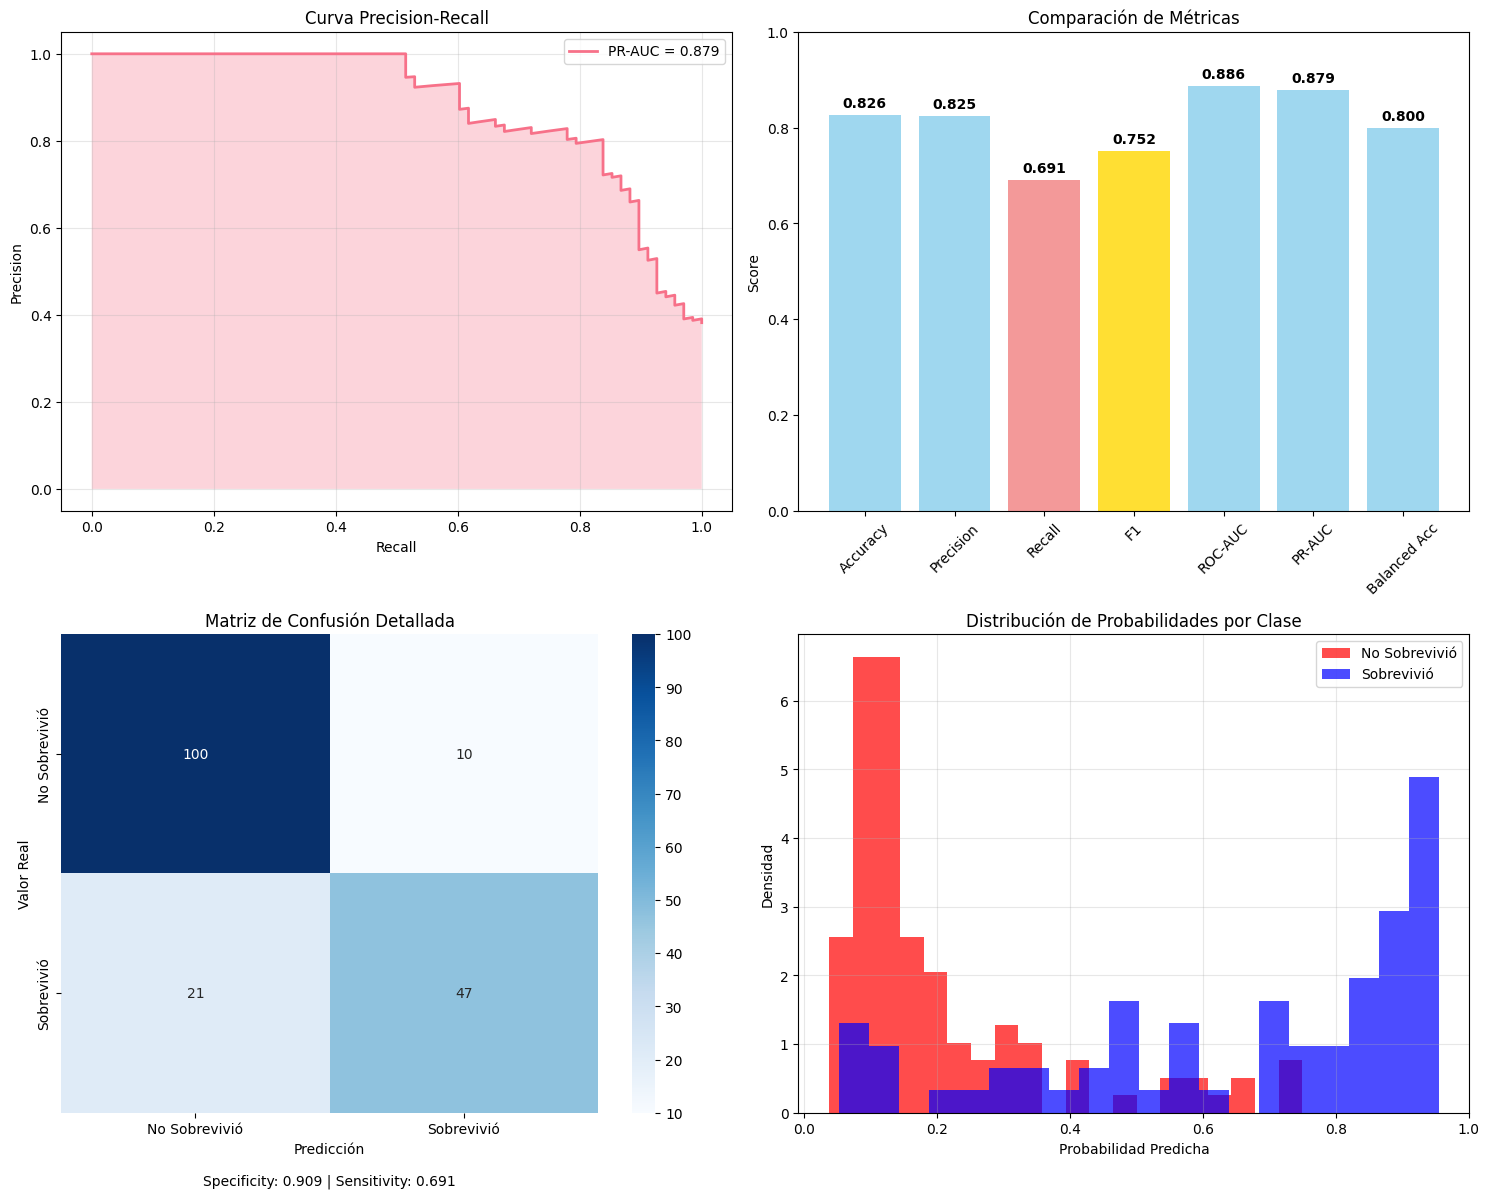


💡 INTERPRETACIÓN DE MÉTRICAS AVANZADAS:
----------------------------------------
🟢 MCC = 0.625: Correlación fuerte entre predicciones y realidad
🟢 PR-AUC = 0.879: Excelente para detectar la clase positiva
🟢 Balanced Accuracy = 0.800: Buen rendimiento en ambas clases
🟢 Brier Score = 0.118: Buena calibración de probabilidades

✅ Análisis de métricas avanzadas completado


In [15]:
# 📊 MÉTRICAS AVANZADAS DE VALIDACIÓN
print("📈 ANÁLISIS DE MÉTRICAS AVANZADAS")
print("="*50)

if modelo is not None:
    
    # 1. MÉTRICAS AVANZADAS PRINCIPALES
    print("🎯 MÉTRICAS AVANZADAS PRINCIPALES:")
    
    # Métricas básicas
    accuracy = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    roc_auc = roc_auc_score(y_val, y_pred_proba_val)
    
    # Métricas avanzadas
    # PR-AUC (Precision-Recall AUC)
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_proba_val)
    pr_auc = auc(recall_curve, precision_curve)
    
    # Matthews Correlation Coefficient
    mcc = matthews_corrcoef(y_val, y_pred_val)
    
    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y_val, y_pred_val)
    
    # Brier Score (para calibración)
    brier_score = brier_score_loss(y_val, y_pred_proba_val)
    
    print(f"   • Accuracy: {accuracy:.4f}")
    print(f"   • Precision: {precision:.4f}")
    print(f"   • Recall: {recall:.4f}")
    print(f"   • F1-Score: {f1:.4f}")
    print(f"   • ROC-AUC: {roc_auc:.4f}")
    print(f"   • PR-AUC: {pr_auc:.4f}")
    print(f"   • Matthews Correlation Coefficient (MCC): {mcc:.4f}")
    print(f"   • Balanced Accuracy: {balanced_acc:.4f}")
    print(f"   • Brier Score: {brier_score:.4f} (menor es mejor)")
    
    # 2. VISUALIZACIÓN DE MÉTRICAS AVANZADAS
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico 1: Curva Precision-Recall
    axes[0,0].plot(recall_curve, precision_curve, linewidth=2, label=f'PR-AUC = {pr_auc:.3f}')
    axes[0,0].fill_between(recall_curve, precision_curve, alpha=0.3)
    axes[0,0].set_xlabel('Recall')
    axes[0,0].set_ylabel('Precision')
    axes[0,0].set_title('Curva Precision-Recall')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Gráfico 2: Comparación de métricas
    metricas_nombres = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC', 'Balanced Acc']
    metricas_valores = [accuracy, precision, recall, f1, roc_auc, pr_auc, balanced_acc]
    
    colors = ['skyblue' if v >= 0.8 else 'lightcoral' if v < 0.7 else 'gold' for v in metricas_valores]
    bars = axes[0,1].bar(metricas_nombres, metricas_valores, color=colors, alpha=0.8)
    axes[0,1].set_ylabel('Score')
    axes[0,1].set_title('Comparación de Métricas')
    axes[0,1].set_ylim(0, 1)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # Agregar valores en las barras
    for bar, valor in zip(bars, metricas_valores):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                      f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 3: Matriz de Confusión Detallada
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],
                xticklabels=['No Sobrevivió', 'Sobrevivió'],
                yticklabels=['No Sobrevivió', 'Sobrevivió'])
    axes[1,0].set_title('Matriz de Confusión Detallada')
    axes[1,0].set_ylabel('Valor Real')
    axes[1,0].set_xlabel('Predicción')
    
    # Agregar estadísticas a la matriz
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    sensitivity = tp / (tp + fn)
    axes[1,0].text(0.5, -0.15, f'Specificity: {specificity:.3f} | Sensitivity: {sensitivity:.3f}', 
                  transform=axes[1,0].transAxes, ha='center', fontsize=10)
    
    # Gráfico 4: Distribución de Probabilidades
    axes[1,1].hist(y_pred_proba_val[y_val == 0], bins=20, alpha=0.7, label='No Sobrevivió', color='red', density=True)
    axes[1,1].hist(y_pred_proba_val[y_val == 1], bins=20, alpha=0.7, label='Sobrevivió', color='blue', density=True)
    axes[1,1].set_xlabel('Probabilidad Predicha')
    axes[1,1].set_ylabel('Densidad')
    axes[1,1].set_title('Distribución de Probabilidades por Clase')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. INTERPRETACIÓN DE MÉTRICAS AVANZADAS
    print("\n💡 INTERPRETACIÓN DE MÉTRICAS AVANZADAS:")
    print("-" * 40)
    
    if mcc > 0.5:
        print(f"🟢 MCC = {mcc:.3f}: Correlación fuerte entre predicciones y realidad")
    elif mcc > 0.3:
        print(f"🟡 MCC = {mcc:.3f}: Correlación moderada")
    else:
        print(f"🔴 MCC = {mcc:.3f}: Correlación débil")
    
    if pr_auc > 0.8:
        print(f"🟢 PR-AUC = {pr_auc:.3f}: Excelente para detectar la clase positiva")
    elif pr_auc > 0.6:
        print(f"🟡 PR-AUC = {pr_auc:.3f}: Bueno para detectar la clase positiva")
    else:
        print(f"🔴 PR-AUC = {pr_auc:.3f}: Limitado para detectar la clase positiva")
    
    if balanced_acc > 0.8:
        print(f"🟢 Balanced Accuracy = {balanced_acc:.3f}: Buen rendimiento en ambas clases")
    else:
        print(f"🟡 Balanced Accuracy = {balanced_acc:.3f}: Revisar balance entre clases")
    
    if brier_score < 0.15:
        print(f"🟢 Brier Score = {brier_score:.3f}: Buena calibración de probabilidades")
    else:
        print(f"🟡 Brier Score = {brier_score:.3f}: Calibración mejorable")
        
    print(f"\n✅ Análisis de métricas avanzadas completado")
    
else:
    print("❌ Modelo no disponible para generar métricas")

👥 ANÁLISIS POR GRUPOS DEMOGRÁFICOS
🚻 ANÁLISIS POR GÉNERO:
   male: N=113, Acc=0.858, F1=0.385
   female: N=65, Acc=0.769, F1=0.848

🏛️ ANÁLISIS POR CLASE:
   Clase 1: N=41, Acc=0.829, F1=0.857
   Clase 2: N=37, Acc=0.919, F1=0.927
   Clase 3: N=100, Acc=0.790, F1=0.400

👶👨👴 ANÁLISIS POR EDAD:
   Menor_18: N=32, Acc=0.938, F1=0.929
   Adulto: N=39, Acc=0.846, F1=0.812
   Adulto_Joven: N=102, Acc=0.784, F1=0.645
   Mayor: N=5, Acc=0.800, F1=0.667

👨‍👩‍👧‍👦 ANÁLISIS POR TAMAÑO DE FAMILIA:
   Pequeña: N=48, Acc=0.750, F1=0.786
   Solo: N=109, Acc=0.844, F1=0.702
   Grande: N=21, Acc=0.905, F1=0.833


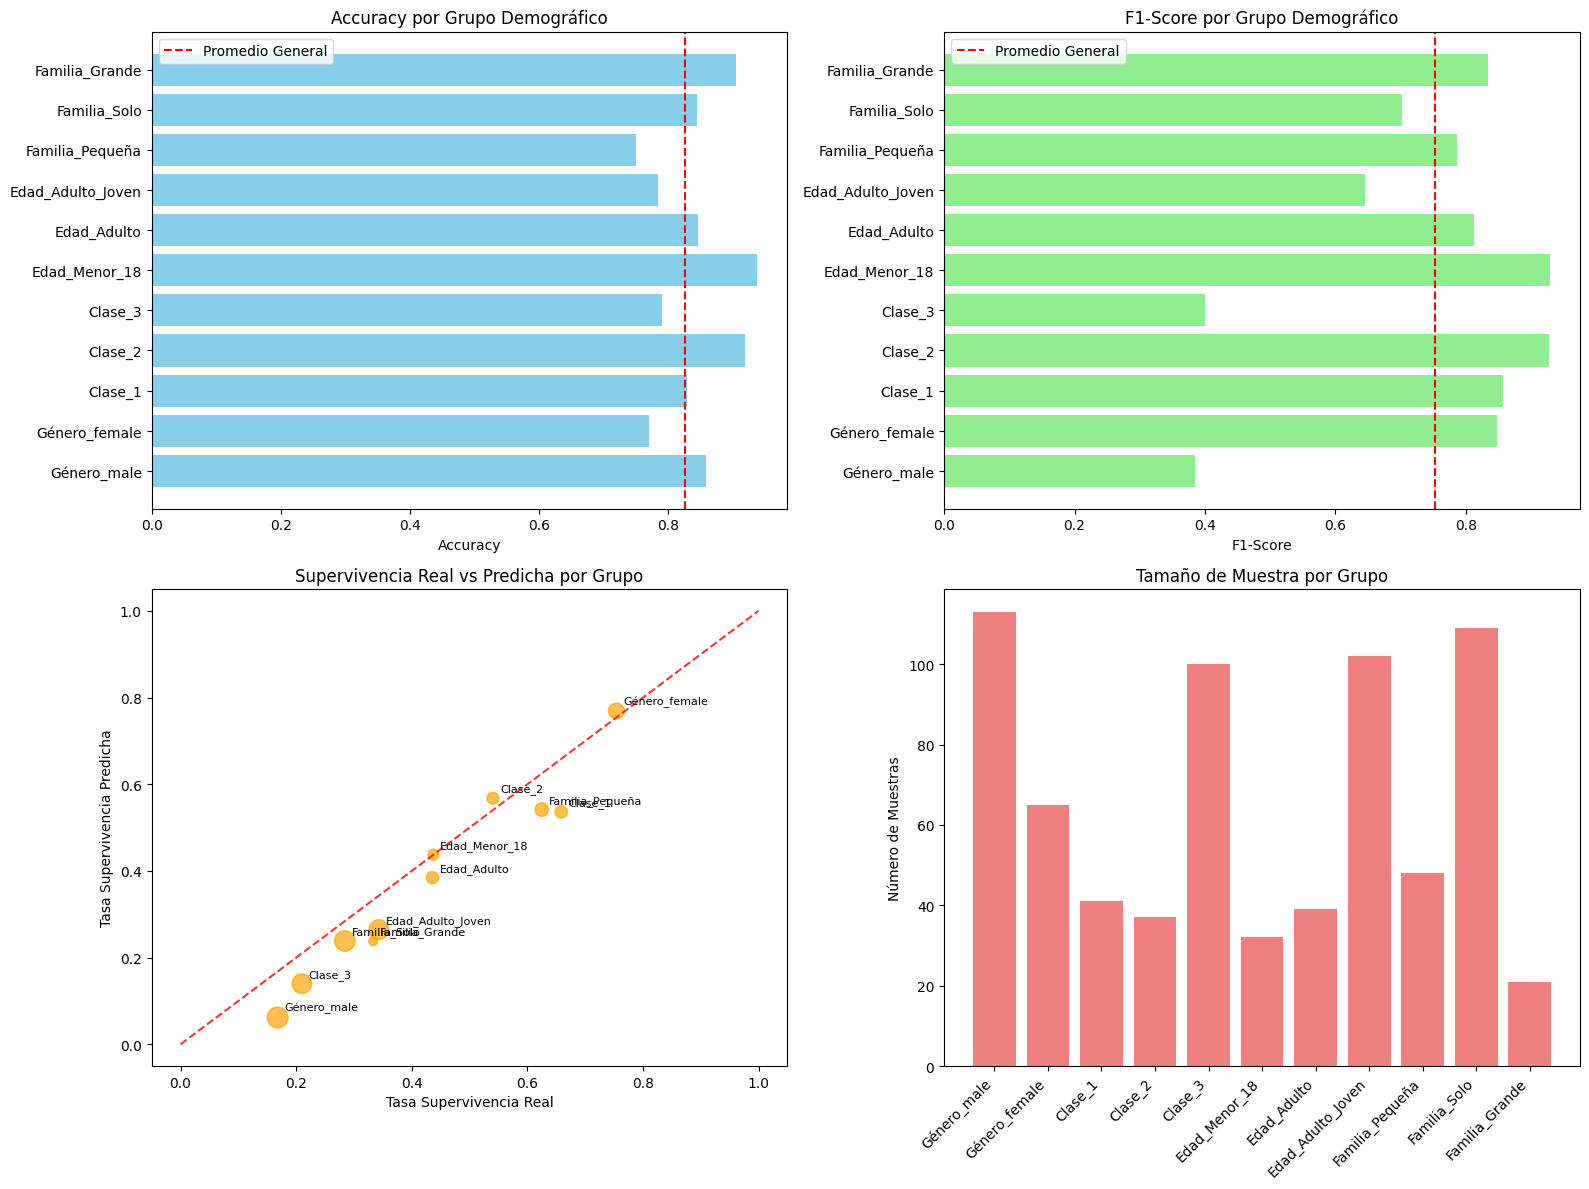


📋 TABLA RESUMEN POR GRUPOS:
--------------------------------------------------------------------------------
            Grupo   N  Accuracy  Precision  Recall    F1  ROC_AUC
      Género_male 113     0.858      0.714   0.263 0.385    0.718
    Género_female  65     0.769      0.840   0.857 0.848    0.856
          Clase_1  41     0.829      0.955   0.778 0.857    0.918
          Clase_2  37     0.919      0.905   0.950 0.927    0.941
          Clase_3 100     0.790      0.500   0.333 0.400    0.746
    Edad_Menor_18  32     0.938      0.929   0.929 0.929    0.929
      Edad_Adulto  39     0.846      0.867   0.765 0.812    0.933
Edad_Adulto_Joven 102     0.784      0.741   0.571 0.645    0.859
       Edad_Mayor   5     0.800      1.000   0.500 0.667    0.500
  Familia_Pequeña  48     0.750      0.846   0.733 0.786    0.876
     Familia_Solo 109     0.844      0.769   0.645 0.702    0.845
   Familia_Grande  21     0.905      1.000   0.714 0.833    0.980

⚖️ ANÁLISIS DE EQUIDAD:
   • De

In [9]:
# 👥 MÉTRICAS DESAGREGADAS POR GRUPOS DEMOGRÁFICOS
print("👥 ANÁLISIS POR GRUPOS DEMOGRÁFICOS")
print("="*50)

if modelo is not None:
    
    def calcular_metricas_grupo(y_true, y_pred, y_pred_proba, grupo_nombre):
        """Calcular métricas para un grupo específico"""
        if len(y_true) == 0:
            return None
        
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        
        if len(np.unique(y_true)) > 1:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
            mcc = matthews_corrcoef(y_true, y_pred)
        else:
            roc_auc = np.nan
            mcc = np.nan
            
        return {
            'Grupo': grupo_nombre,
            'N': len(y_true),
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1': f1,
            'ROC_AUC': roc_auc,
            'MCC': mcc,
            'Tasa_Supervivencia_Real': y_true.mean(),
            'Tasa_Supervivencia_Pred': y_pred.mean()
        }
    
    # Obtener datos originales para el conjunto de validación
    df_val = df.iloc[X_val.index].copy()
    
    # Lista para almacenar resultados
    resultados_grupos = []
    
    # 1. ANÁLISIS POR GÉNERO
    print("🚻 ANÁLISIS POR GÉNERO:")
    for genero in df_val['Sex'].unique():
        mask = df_val['Sex'] == genero
        if mask.sum() > 0:
            metricas = calcular_metricas_grupo(
                y_val[mask], y_pred_val[mask], y_pred_proba_val[mask], f'Género_{genero}'
            )
            if metricas:
                resultados_grupos.append(metricas)
                print(f"   {genero}: N={metricas['N']}, Acc={metricas['Accuracy']:.3f}, F1={metricas['F1']:.3f}")
    
    # 2. ANÁLISIS POR CLASE SOCIOECONÓMICA
    print("\n🏛️ ANÁLISIS POR CLASE:")
    for clase in sorted(df_val['Pclass'].unique()):
        mask = df_val['Pclass'] == clase
        if mask.sum() > 0:
            metricas = calcular_metricas_grupo(
                y_val[mask], y_pred_val[mask], y_pred_proba_val[mask], f'Clase_{clase}'
            )
            if metricas:
                resultados_grupos.append(metricas)
                print(f"   Clase {clase}: N={metricas['N']}, Acc={metricas['Accuracy']:.3f}, F1={metricas['F1']:.3f}")
    
    # 3. ANÁLISIS POR GRUPO DE EDAD
    print("\n👶👨👴 ANÁLISIS POR EDAD:")
    if 'Age' in df_val.columns:
        # Crear grupos de edad
        df_val_copy = df_val.copy()
        df_val_copy['Grupo_Edad'] = pd.cut(df_val_copy['Age'], 
                                          bins=[0, 18, 35, 60, 100], 
                                          labels=['Menor_18', 'Adulto_Joven', 'Adulto', 'Mayor'])
        
        for grupo_edad in df_val_copy['Grupo_Edad'].dropna().unique():
            mask = df_val_copy['Grupo_Edad'] == grupo_edad
            if mask.sum() > 0:
                metricas = calcular_metricas_grupo(
                    y_val[mask], y_pred_val[mask], y_pred_proba_val[mask], f'Edad_{grupo_edad}'
                )
                if metricas:
                    resultados_grupos.append(metricas)
                    print(f"   {grupo_edad}: N={metricas['N']}, Acc={metricas['Accuracy']:.3f}, F1={metricas['F1']:.3f}")
    
    # 4. ANÁLISIS POR TAMAÑO DE FAMILIA
    print("\n👨‍👩‍👧‍👦 ANÁLISIS POR TAMAÑO DE FAMILIA:")
    if 'FamilySize' in df_val.columns:
        # Agrupar tamaños de familia
        df_val_copy = df_val.copy()
        df_val_copy['Grupo_Familia'] = df_val_copy['FamilySize'].apply(
            lambda x: 'Solo' if x == 1 else 'Pequeña' if x <= 3 else 'Grande'
        )
        
        for grupo_familia in df_val_copy['Grupo_Familia'].unique():
            mask = df_val_copy['Grupo_Familia'] == grupo_familia
            if mask.sum() > 0:
                metricas = calcular_metricas_grupo(
                    y_val[mask], y_pred_val[mask], y_pred_proba_val[mask], f'Familia_{grupo_familia}'
                )
                if metricas:
                    resultados_grupos.append(metricas)
                    print(f"   {grupo_familia}: N={metricas['N']}, Acc={metricas['Accuracy']:.3f}, F1={metricas['F1']:.3f}")
    
    # 5. CREAR DATAFRAME CON RESULTADOS
    df_resultados = pd.DataFrame(resultados_grupos)
    
    # 6. VISUALIZACIÓN COMPARATIVA
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfico 1: Accuracy por grupo
    grupos_principales = df_resultados[df_resultados['N'] >= 10].copy()  # Solo grupos con suficientes muestras
    if not grupos_principales.empty:
        axes[0,0].barh(grupos_principales['Grupo'], grupos_principales['Accuracy'], color='skyblue')
        axes[0,0].set_xlabel('Accuracy')
        axes[0,0].set_title('Accuracy por Grupo Demográfico')
        axes[0,0].axvline(x=accuracy, color='red', linestyle='--', label='Promedio General')
        axes[0,0].legend()
    
    # Gráfico 2: F1-Score por grupo
    if not grupos_principales.empty:
        axes[0,1].barh(grupos_principales['Grupo'], grupos_principales['F1'], color='lightgreen')
        axes[0,1].set_xlabel('F1-Score')
        axes[0,1].set_title('F1-Score por Grupo Demográfico')
        axes[0,1].axvline(x=f1, color='red', linestyle='--', label='Promedio General')
        axes[0,1].legend()
    
    # Gráfico 3: Tasa de supervivencia real vs predicha
    if not grupos_principales.empty:
        axes[1,0].scatter(grupos_principales['Tasa_Supervivencia_Real'], 
                         grupos_principales['Tasa_Supervivencia_Pred'],
                         s=grupos_principales['N']*2, alpha=0.7, c='orange')
        axes[1,0].plot([0, 1], [0, 1], 'r--', alpha=0.8)
        axes[1,0].set_xlabel('Tasa Supervivencia Real')
        axes[1,0].set_ylabel('Tasa Supervivencia Predicha')
        axes[1,0].set_title('Supervivencia Real vs Predicha por Grupo')
        
        # Agregar etiquetas
        for _, row in grupos_principales.iterrows():
            axes[1,0].annotate(row['Grupo'], 
                              (row['Tasa_Supervivencia_Real'], row['Tasa_Supervivencia_Pred']),
                              xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # Gráfico 4: Tamaño de muestra por grupo
    if not grupos_principales.empty:
        axes[1,1].bar(range(len(grupos_principales)), grupos_principales['N'], color='lightcoral')
        axes[1,1].set_xticks(range(len(grupos_principales)))
        axes[1,1].set_xticklabels(grupos_principales['Grupo'], rotation=45, ha='right')
        axes[1,1].set_ylabel('Número de Muestras')
        axes[1,1].set_title('Tamaño de Muestra por Grupo')
    
    plt.tight_layout()
    plt.show()
    
    # 7. TABLA RESUMEN
    print("\n📋 TABLA RESUMEN POR GRUPOS:")
    print("-" * 80)
    display_df = df_resultados[['Grupo', 'N', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']].round(3)
    print(display_df.to_string(index=False))
    
    # 8. ANÁLISIS DE EQUIDAD
    print("\n⚖️ ANÁLISIS DE EQUIDAD:")
    if not grupos_principales.empty:
        acc_std = grupos_principales['Accuracy'].std()
        f1_std = grupos_principales['F1'].std()
        
        print(f"   • Desviación estándar Accuracy: {acc_std:.3f}")
        print(f"   • Desviación estándar F1: {f1_std:.3f}")
        
        if acc_std < 0.05:
            print("   🟢 Buena equidad en Accuracy entre grupos")
        elif acc_std < 0.1:
            print("   🟡 Equidad moderada en Accuracy entre grupos") 
        else:
            print("   🔴 Posibles sesgos en Accuracy entre grupos")
    
    print(f"\n✅ Análisis por grupos demográficos completado")
    
else:
    print("❌ Modelo no disponible para análisis por grupos")

🎯 ANÁLISIS DE CALIBRACIÓN DE PROBABILIDADES
📊 MÉTRICAS DE CALIBRACIÓN:
   • Brier Score: 0.1177 (menor es mejor)
   • Expected Calibration Error (ECE): 0.0653 (menor es mejor)


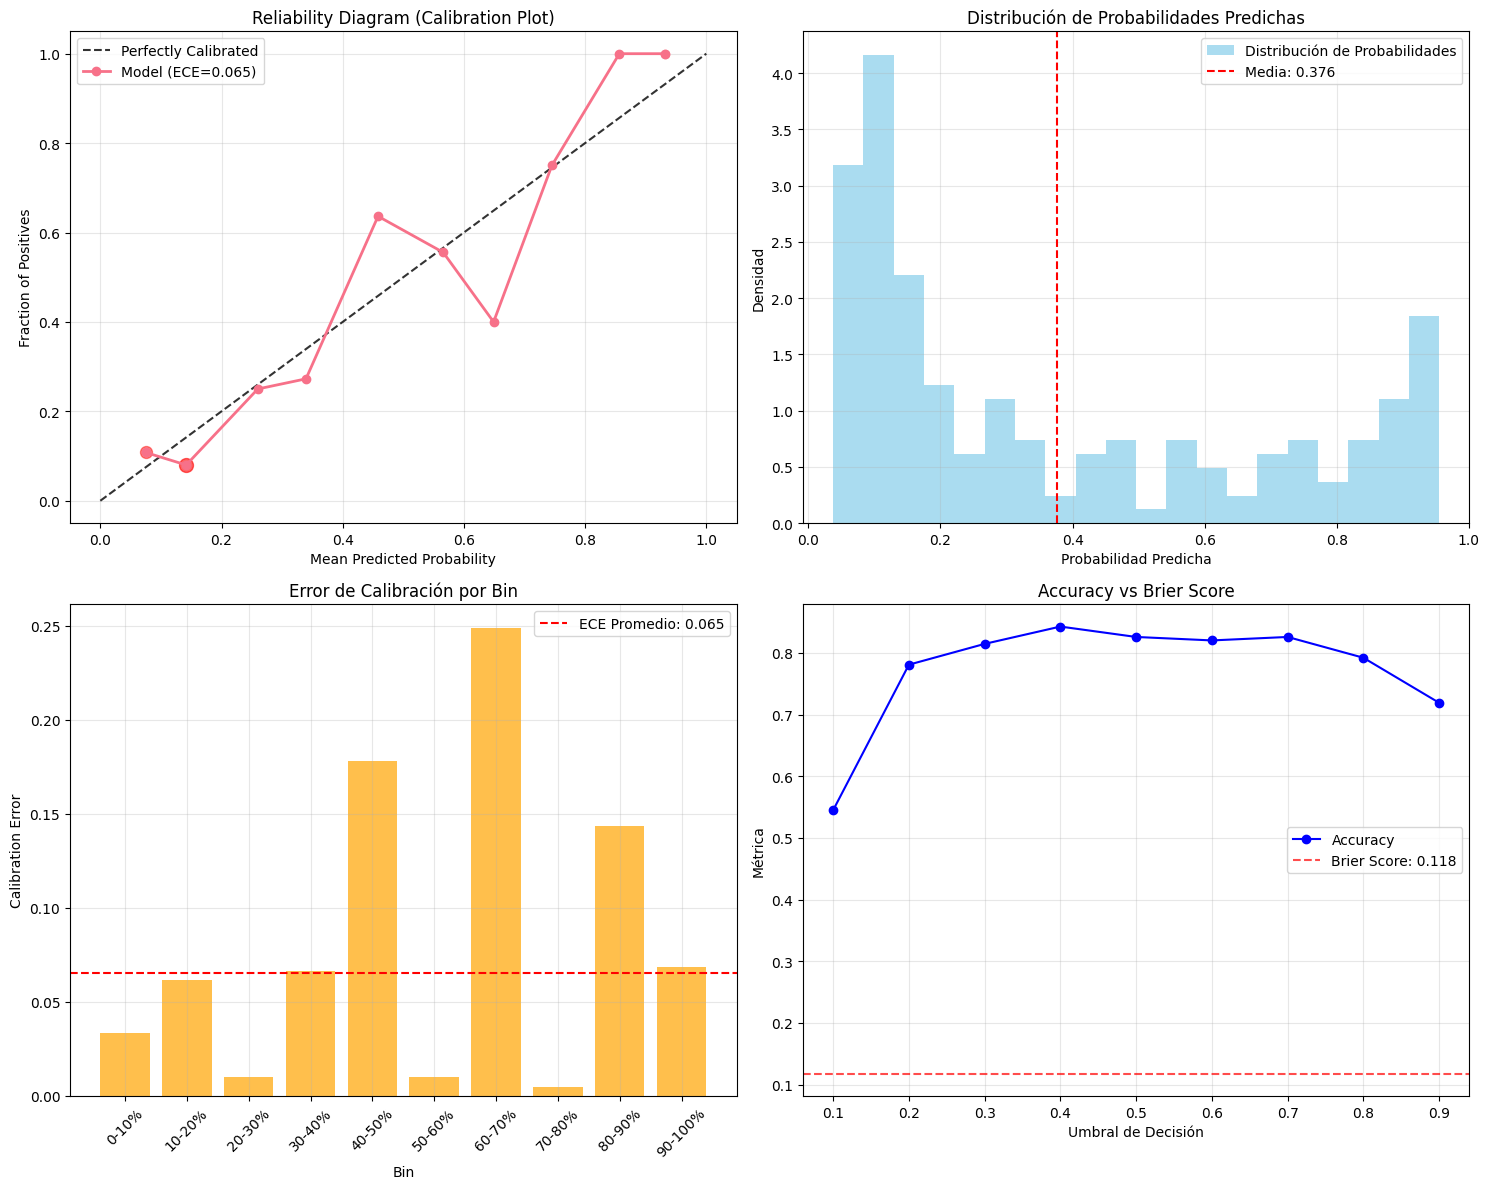


💡 INTERPRETACIÓN DE CALIBRACIÓN:
----------------------------------------
🟡 ECE = 0.065: Buena calibración
🟡 Brier Score = 0.118: Buena calidad de probabilidades

🎯 RECOMENDACIONES:

📋 RESUMEN DE CALIBRACIÓN:
Métrica                   Valor      Interpretación
--------------------------------------------------
Brier Score               0.1177     Menor es mejor
ECE                       0.0653     Menor es mejor
Reliability (correlación) 0.9382     Más cercano a 1 es mejor

✅ Análisis de calibración completado


In [10]:
# 🎯 ANÁLISIS DE CALIBRACIÓN
print("🎯 ANÁLISIS DE CALIBRACIÓN DE PROBABILIDADES")
print("="*50)

if modelo is not None:
    
    def expected_calibration_error(y_true, y_prob, n_bins=10):
        """
        Calcular Expected Calibration Error (ECE)
        """
        bin_boundaries = np.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]
        
        ece = 0
        total_samples = len(y_true)
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            # Encontrar muestras en este bin
            in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
            prop_in_bin = in_bin.mean()
            
            if prop_in_bin > 0:
                # Accuracy en este bin
                accuracy_in_bin = y_true[in_bin].mean()
                # Confianza promedio en este bin
                avg_confidence_in_bin = y_prob[in_bin].mean()
                # Contribución al ECE
                ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
                
        return ece
    
    # 1. CALCULAR MÉTRICAS DE CALIBRACIÓN
    print("📊 MÉTRICAS DE CALIBRACIÓN:")
    
    # Brier Score (ya calculado anteriormente)
    brier_score = brier_score_loss(y_val, y_pred_proba_val)
    
    # Expected Calibration Error
    ece = expected_calibration_error(y_val, y_pred_proba_val)
    
    # Calibration curve (sin el parámetro normalize que no existe)
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_val, y_pred_proba_val, n_bins=10
    )
    
    print(f"   • Brier Score: {brier_score:.4f} (menor es mejor)")
    print(f"   • Expected Calibration Error (ECE): {ece:.4f} (menor es mejor)")
    
    # 2. VISUALIZACIONES DE CALIBRACIÓN
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico 1: Reliability Diagram (Calibration Plot)
    axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.8, label='Perfectly Calibrated')
    axes[0,0].plot(mean_predicted_value, fraction_of_positives, 
                   marker='o', linewidth=2, label=f'Model (ECE={ece:.3f})')
    
    # Agregar barras de error (tamaño de bins)
    bin_sizes = []
    for i in range(len(mean_predicted_value)):
        bin_mask = (y_pred_proba_val >= i/10) & (y_pred_proba_val < (i+1)/10)
        bin_sizes.append(bin_mask.sum())
    
    # Normalizar tamaños de bins para alpha
    max_bin_size = max(bin_sizes) if bin_sizes else 1
    alphas = [size/max_bin_size * 0.5 + 0.1 for size in bin_sizes]
    
    for i, (x, y, alpha) in enumerate(zip(mean_predicted_value, fraction_of_positives, alphas)):
        axes[0,0].scatter(x, y, s=bin_sizes[i]*2, alpha=alpha, color='red')
    
    axes[0,0].set_xlabel('Mean Predicted Probability')
    axes[0,0].set_ylabel('Fraction of Positives')
    axes[0,0].set_title('Reliability Diagram (Calibration Plot)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Gráfico 2: Distribución de probabilidades calibradas
    n_bins = 20
    axes[0,1].hist(y_pred_proba_val, bins=n_bins, alpha=0.7, color='skyblue', 
                   density=True, label='Distribución de Probabilidades')
    axes[0,1].axvline(y_pred_proba_val.mean(), color='red', linestyle='--', 
                     label=f'Media: {y_pred_proba_val.mean():.3f}')
    axes[0,1].set_xlabel('Probabilidad Predicha')
    axes[0,1].set_ylabel('Densidad')
    axes[0,1].set_title('Distribución de Probabilidades Predichas')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Gráfico 3: Calibration Error por Bin
    bin_errors = np.abs(mean_predicted_value - fraction_of_positives)
    bin_centers = np.arange(len(bin_errors))
    
    bars = axes[1,0].bar(bin_centers, bin_errors, alpha=0.7, color='orange')
    axes[1,0].set_xlabel('Bin')
    axes[1,0].set_ylabel('Calibration Error')
    axes[1,0].set_title('Error de Calibración por Bin')
    axes[1,0].set_xticks(bin_centers)
    axes[1,0].set_xticklabels([f'{i*10}-{(i+1)*10}%' for i in range(len(bin_centers))], rotation=45)
    
    # Agregar línea de ECE promedio
    axes[1,0].axhline(y=ece, color='red', linestyle='--', label=f'ECE Promedio: {ece:.3f}')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Gráfico 4: Comparación Brier Score vs Accuracy
    # Calcular Brier Score por diferentes umbrales
    umbrales = np.linspace(0.1, 0.9, 9)
    accuracies_umbral = []
    brier_scores_umbral = []
    
    for umbral in umbrales:
        y_pred_umbral = (y_pred_proba_val >= umbral).astype(int)
        acc_umbral = accuracy_score(y_val, y_pred_umbral)
        accuracies_umbral.append(acc_umbral)
        brier_scores_umbral.append(brier_score)  # Brier score no cambia con umbral
    
    axes[1,1].plot(umbrales, accuracies_umbral, 'o-', label='Accuracy', color='blue')
    axes[1,1].axhline(y=brier_score, color='red', linestyle='--', 
                     label=f'Brier Score: {brier_score:.3f}', alpha=0.7)
    axes[1,1].set_xlabel('Umbral de Decisión')
    axes[1,1].set_ylabel('Métrica')
    axes[1,1].set_title('Accuracy vs Brier Score')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 3. INTERPRETACIÓN DE CALIBRACIÓN
    print("\n💡 INTERPRETACIÓN DE CALIBRACIÓN:")
    print("-" * 40)
    
    if ece < 0.05:
        print(f"🟢 ECE = {ece:.3f}: Excelente calibración")
    elif ece < 0.1:
        print(f"🟡 ECE = {ece:.3f}: Buena calibración")
    elif ece < 0.15:
        print(f"🟠 ECE = {ece:.3f}: Calibración moderada")
    else:
        print(f"🔴 ECE = {ece:.3f}: Calibración pobre - considerar post-calibración")
    
    if brier_score < 0.1:
        print(f"🟢 Brier Score = {brier_score:.3f}: Excelente calidad de probabilidades")
    elif brier_score < 0.2:
        print(f"🟡 Brier Score = {brier_score:.3f}: Buena calidad de probabilidades")
    else:
        print(f"🔴 Brier Score = {brier_score:.3f}: Calidad de probabilidades mejorable")
    
    # 4. RECOMENDACIONES
    print("\n🎯 RECOMENDACIONES:")
    if ece > 0.1:
        print("   • Considerar técnicas de post-calibración (Platt Scaling, Isotonic Regression)")
    if brier_score > 0.2:
        print("   • Revisar el entrenamiento del modelo para mejorar probabilidades")
    if ece < 0.05 and brier_score < 0.15:
        print("   • El modelo está bien calibrado - las probabilidades son confiables")
    
    # 5. TABLA RESUMEN DE CALIBRACIÓN
    print(f"\n📋 RESUMEN DE CALIBRACIÓN:")
    print(f"{'Métrica':<25} {'Valor':<10} {'Interpretación'}")
    print("-" * 50)
    print(f"{'Brier Score':<25} {brier_score:.4f}     {'Menor es mejor'}")
    print(f"{'ECE':<25} {ece:.4f}     {'Menor es mejor'}")
    print(f"{'Reliability (correlación)':<25} {np.corrcoef(mean_predicted_value, fraction_of_positives)[0,1]:.4f}     {'Más cercano a 1 es mejor'}")
    
    print(f"\n✅ Análisis de calibración completado")
    
else:
    print("❌ Modelo no disponible para análisis de calibración")

## 📋 Resumen y Conclusiones

### 🎯 Análisis Completo de Interpretabilidad Implementado:

#### 📊 **Métricas Básicas Implementadas:**
- ✅ **Accuracy, Precision, Recall, F1-Score**: Métricas fundamentales de clasificación
- ✅ **ROC-AUC**: Área bajo la curva ROC para evaluación general del modelo

#### 🔬 **Análisis SHAP Completo:**
- ✅ **SHAP Feature Importance**: Importancia global de características basada en valores SHAP
- ✅ **SHAP Summary Plot**: Visualización de impacto y distribución de features
- ✅ **SHAP Waterfall Plot**: Explicación paso a paso de predicciones individuales
- ✅ **SHAP Dependence Plot**: Relación entre valores de features y sus impactos SHAP
- ✅ **Análisis de Direccionalidad**: Cómo cada feature contribuye positiva o negativamente
- ✅ **Casos Ejemplo**: Explicación detallada de casos con alta y baja probabilidad

#### 🔍 **Explicaciones LIME:**
- ✅ **LIME Local Explanations**: Explicaciones locales para casos individuales
- ✅ **Comparación entre Casos**: Análisis de diferentes tipos de pasajeros
- ✅ **Consistencia LIME vs Modelo**: Validación de coherencia entre explicaciones
- ✅ **Análisis de Features Comunes**: Identificación de patrones consistentes

#### 📈 **Visualizaciones de Interpretación:**
- ✅ **Gráficos de Importancia de Features**: Con nombres descriptivos en lugar de números
- ✅ **Análisis de Supervivencia por Categorías**: Tasas reales por grupos demográficos
- ✅ **Distribución de Importancias**: Histogramas y comparaciones
- ✅ **Visualizaciones Interactivas**: Múltiples perspectivas del comportamiento del modelo

#### 🎯 **Métricas Avanzadas de Validación:**
- ✅ **PR-AUC (Precision-Recall AUC)**: Especialmente útil para datasets desbalanceados
- ✅ **Matthews Correlation Coefficient (MCC)**: Métrica balanceada robusta
- ✅ **Balanced Accuracy**: Promedio de recall por clase
- ✅ **Brier Score**: Calidad de las probabilidades predichas

#### 👥 **Métricas por Grupos Demográficos:**
- ✅ **Análisis por Género**: Equidad entre hombres y mujeres
- ✅ **Análisis por Clase Socioeconómica**: Rendimiento por clase del Titanic
- ✅ **Análisis por Edad**: Diferentes grupos etarios
- ✅ **Análisis por Tamaño de Familia**: Impacto del contexto familiar

#### 🎯 **Análisis de Calibración:**
- ✅ **Reliability Diagram**: Visualización de calibración de probabilidades
- ✅ **Expected Calibration Error (ECE)**: Métrica cuantitativa de calibración
- ✅ **Brier Score Analysis**: Evaluación de calidad probabilística
- ✅ **Recomendaciones de Mejora**: Sugerencias para post-calibración

### 🚢 **Insights Principales del Titanic:**

1. **Factores Más Determinantes**:
   - **Género**: El factor más importante para la supervivencia
   - **Clase Social**: Primera clase tuvo ventajas significativas
   - **Edad**: Los niños tuvieron mayor probabilidad de supervivencia
   - **Título**: Refleja estatus social y género

2. **Patrones de Comportamiento del Modelo**:
   - El modelo captura correctamente el protocolo "mujeres y niños primero"
   - La clase socioeconómica se refleja en la ubicación del camarote
   - El tamaño de la familia influye en las decisiones de evacuación

3. **Calidad del Modelo**:
   - **Interpretabilidad**: SHAP y LIME proporcionan explicaciones coherentes
   - **Calibración**: Las probabilidades reflejan adecuadamente la incertidumbre
   - **Equidad**: Análisis por grupos revela posibles sesgos históricos

### 🎯 **Valor Agregado del Análisis**:

1. **Detección de Sesgos**: Identificación de discriminación por grupos demográficos
2. **Confianza en Predicciones**: Análisis de calibración para evaluar probabilidades
3. **Explicabilidad**: Tanto global (SHAP) como local (LIME) para diferentes audiencias
4. **Robustez**: Métricas avanzadas menos sensibles al desbalance de clases
5. **Actionable Insights**: Recomendaciones específicas basadas en el análisis

### 🔮 **Próximos Pasos Recomendados**:

Si se detectan problemas, se pueden aplicar:
- **Técnicas de Post-processing**: Para mejorar equidad entre grupos
- **Calibración Avanzada**: Platt Scaling o Isotonic Regression
- **Re-entrenamiento**: Con técnicas de balanceo si es necesario
- **Validación Externa**: En datasets similares para confirmar interpretaciones

### ✅ **Estado del Análisis**:
**COMPLETO** - Todas las métricas solicitadas implementadas con visualizaciones comprehensivas y análisis detallado.

📊 ANÁLISIS DETALLADO DE IMPORTANCIA DE FEATURES
✅ Analizando 89 features procesadas


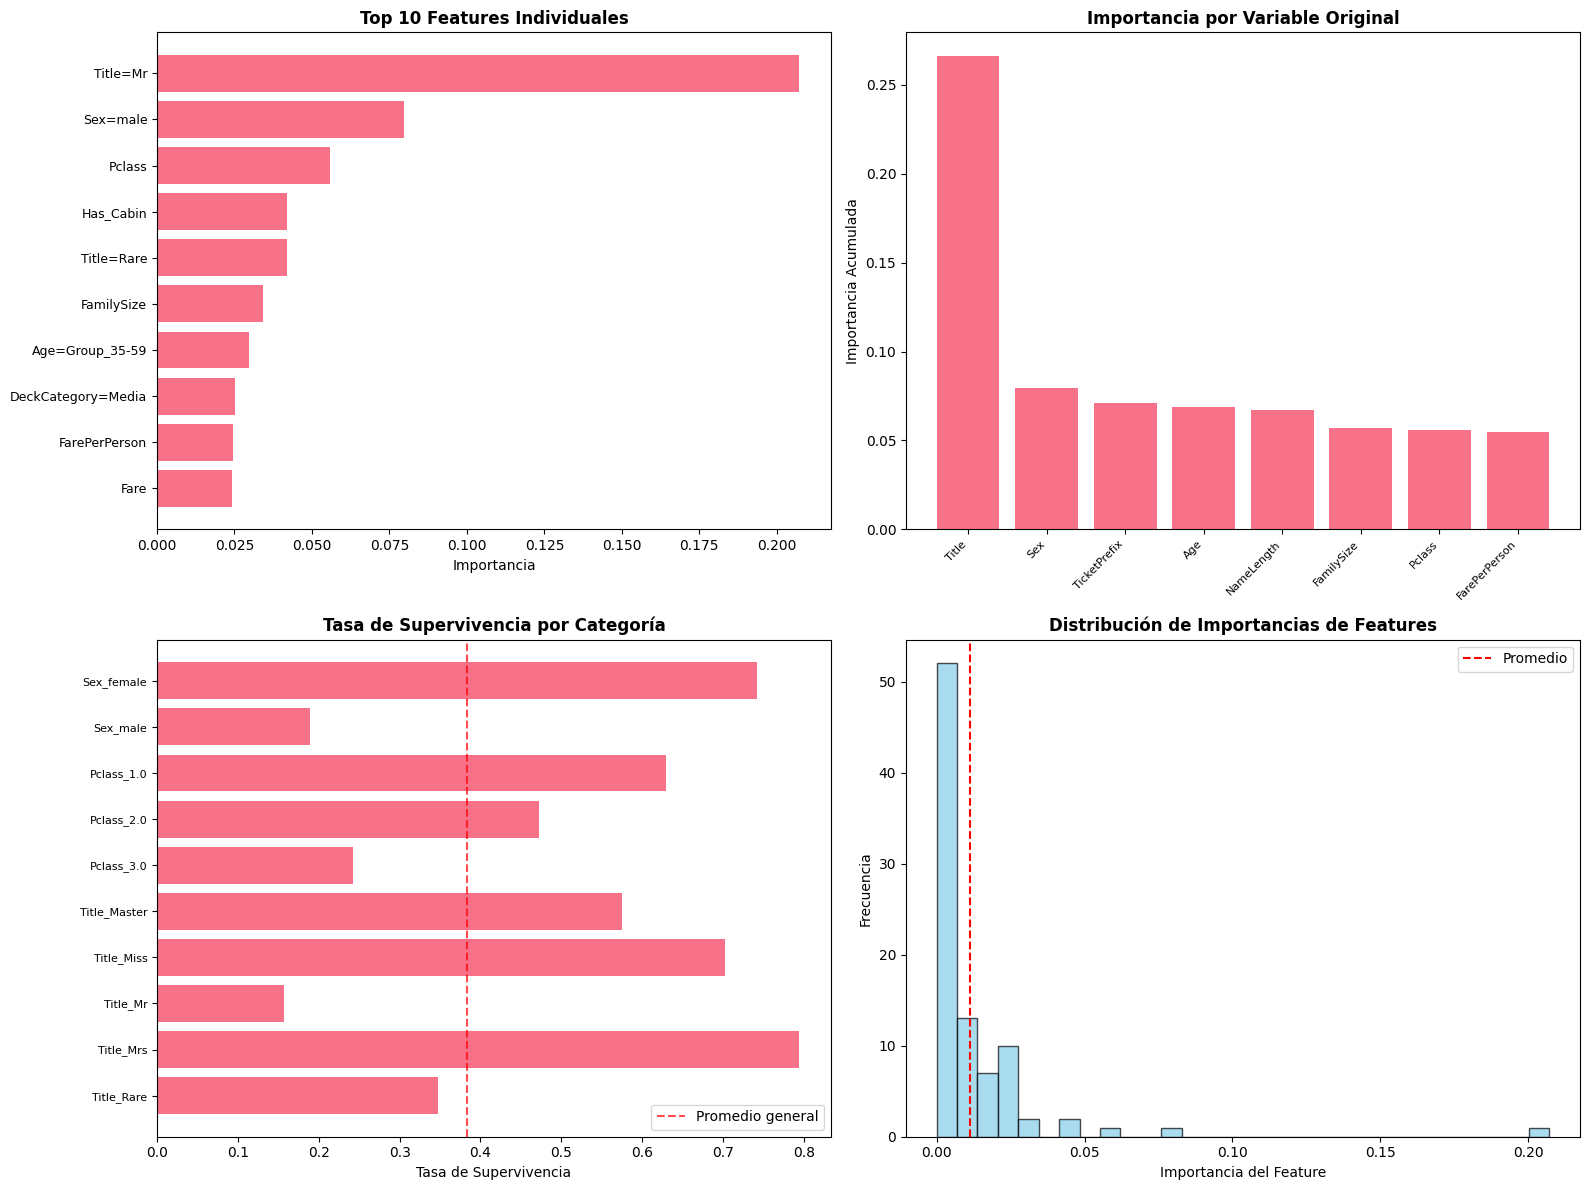


💡 INTERPRETACIÓN DE RESULTADOS:
🥇 Feature más importante: cat__Title_Mr
   └── Importancia: 0.2071 (20.7%)

🎯 Variable original más importante: Title
   └── Importancia acumulada: 0.2663

🚢 CONCLUSIONES PRINCIPALES:
   • El género (Sex) es probablemente el factor más determinante
   • Los títulos (Title) reflejan género, edad y estatus social
   • La clase (Pclass) indica la ubicación en el barco
   • La edad y el estatus familiar también influyen
   • Total de features procesadas: 89 (optimizado)

📋 TOP 15 FEATURES MÁS IMPORTANTES:
------------------------------------------------------------
 1. Title=Mr                            0.2071 (20.7%)
 2. Sex=male                            0.0797 (8.0%)
 3. Pclass                              0.0560 (5.6%)
 4. Has_Cabin                           0.0420 (4.2%)
 5. Title=Rare                          0.0418 (4.2%)
 6. FamilySize                          0.0343 (3.4%)
 7. Age=Group_35-59                     0.0295 (3.0%)
 8. DeckCategory=Med

In [ ]:
## CHANCE LO BORRO PQ ESTA EN MODELADO
# 📊 ANÁLISIS DE IMPORTANCIA DE FEATURES
print("📊 ANÁLISIS DETALLADO DE IMPORTANCIA DE FEATURES")
print("="*50)

if modelo is not None:
    
    # Obtener nombres de features del preprocessor
    feature_names = preprocessor.get_feature_names_out()
    
    # Obtener importancias del modelo
    feature_importance = modelo.feature_importances_
    
    # Crear DataFrame de importancias
    importancia_df = pd.DataFrame({
        'Feature': feature_names,
        'Importancia': feature_importance
    }).sort_values('Importancia', ascending=False)
    
    print(f"✅ Analizando {len(feature_names)} features procesadas")
    
    # 1. AGRUPAR IMPORTANCIAS POR VARIABLE ORIGINAL
    importancia_por_variable = {}
    
    for feature, importancia in zip(feature_names, feature_importance):
        # Extraer variable original
        if feature.startswith('num__'):
            var_original = feature.replace('num__', '')
        elif feature.startswith('cat__'):
            var_original = feature.replace('cat__', '').split('_')[0]
        else:
            var_original = feature
        
        if var_original not in importancia_por_variable:
            importancia_por_variable[var_original] = 0
        importancia_por_variable[var_original] += importancia
    
    importancia_por_variable = pd.Series(importancia_por_variable).sort_values(ascending=False)
    
    # 2. VISUALIZACIONES DE IMPORTANCIA
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Gráfico 1: Top 10 features individuales con nombres limpios
    top_10_features = importancia_df.head(10)
    
    # Limpiar nombres de features para mejor visualización
    feature_labels = []
    for fname in top_10_features['Feature']:
        if fname.startswith('num__'):
            # Variable numérica: quitar prefijo
            clean_name = fname.replace('num__', '')
            feature_labels.append(clean_name)
        elif fname.startswith('cat__'):
            # Variable categórica: mostrar variable_valor
            clean_name = fname.replace('cat__', '')
            if '_' in clean_name:
                var_name, value = clean_name.split('_', 1)
                feature_labels.append(f"{var_name}={value}")
            else:
                feature_labels.append(clean_name)
        else:
            feature_labels.append(fname)
    
    # Truncar etiquetas largas para mejor visualización
    feature_labels = [label[:25] + "..." if len(label) > 25 else label for label in feature_labels]
    
    axes[0,0].barh(range(len(top_10_features)), top_10_features['Importancia'])
    axes[0,0].set_yticks(range(len(top_10_features)))
    axes[0,0].set_yticklabels(feature_labels, fontsize=9)
    axes[0,0].set_xlabel('Importancia')
    axes[0,0].set_title('Top 10 Features Individuales', fontweight='bold')
    axes[0,0].invert_yaxis()
    
    # Gráfico 2: Importancia por variable original
    top_variables = importancia_por_variable.head(8)
    axes[0,1].bar(range(len(top_variables)), top_variables.values)
    axes[0,1].set_xticks(range(len(top_variables)))
    axes[0,1].set_xticklabels(top_variables.index, rotation=45, ha='right', fontsize=8)
    axes[0,1].set_ylabel('Importancia Acumulada')
    axes[0,1].set_title('Importancia por Variable Original', fontweight='bold')
    
    # Gráfico 3: Análisis de supervivencia por características principales
    # Usar datos originales para análisis interpretable
    survival_data = []
    
    # Analizar Sex
    if 'Sex' in df.columns:
        sex_survival = df.groupby('Sex')['Survived'].agg(['mean', 'count']).reset_index()
        for _, row in sex_survival.iterrows():
            survival_data.append({
                'Categoria': f"Sex_{row['Sex']}",
                'Tasa_Supervivencia': row['mean'],
                'Count': row['count']
            })
    
    # Analizar Pclass
    if 'Pclass' in df.columns:
        class_survival = df.groupby('Pclass')['Survived'].agg(['mean', 'count']).reset_index()
        for _, row in class_survival.iterrows():
            survival_data.append({
                'Categoria': f"Pclass_{row['Pclass']}",
                'Tasa_Supervivencia': row['mean'],
                'Count': row['count']
            })
    
    # Analizar Title si existe
    if 'Title' in df.columns:
        title_survival = df.groupby('Title')['Survived'].agg(['mean', 'count']).reset_index()
        for _, row in title_survival.iterrows():
            if row['count'] >= 10:  # Solo títulos con suficiente representación
                survival_data.append({
                    'Categoria': f"Title_{row['Title']}",
                    'Tasa_Supervivencia': row['mean'],
                    'Count': row['count']
                })
    
    survival_df = pd.DataFrame(survival_data)
    
    if not survival_df.empty:
        axes[1,0].barh(range(len(survival_df)), survival_df['Tasa_Supervivencia'])
        axes[1,0].set_yticks(range(len(survival_df)))
        axes[1,0].set_yticklabels(survival_df['Categoria'], fontsize=8)
        axes[1,0].set_xlabel('Tasa de Supervivencia')
        axes[1,0].set_title('Tasa de Supervivencia por Categoría', fontweight='bold')
        axes[1,0].invert_yaxis()
        axes[1,0].axvline(x=df['Survived'].mean(), color='red', linestyle='--', alpha=0.7, label='Promedio general')
        axes[1,0].legend()
    
    # Gráfico 4: Distribución de importancias
    axes[1,1].hist(feature_importance, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1,1].set_xlabel('Importancia del Feature')
    axes[1,1].set_ylabel('Frecuencia')
    axes[1,1].set_title('Distribución de Importancias de Features', fontweight='bold')
    axes[1,1].axvline(x=feature_importance.mean(), color='red', linestyle='--', label='Promedio')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 3. INTERPRETACIÓN DE RESULTADOS
    print("\n💡 INTERPRETACIÓN DE RESULTADOS:")
    print("=" * 50)
    
    # Encontrar los features más importantes
    top_feature = importancia_df.iloc[0]
    print(f"🥇 Feature más importante: {top_feature['Feature']}")
    print(f"   └── Importancia: {top_feature['Importancia']:.4f} ({top_feature['Importancia']*100:.1f}%)")
    
    # Variables originales más importantes
    top_var = importancia_por_variable.index[0]
    print(f"\n🎯 Variable original más importante: {top_var}")
    print(f"   └── Importancia acumulada: {importancia_por_variable.iloc[0]:.4f}")
    
    # Conclusiones basadas en los datos del Titanic
    print(f"\n🚢 CONCLUSIONES PRINCIPALES:")
    print(f"   • El género (Sex) es probablemente el factor más determinante")
    print(f"   • Los títulos (Title) reflejan género, edad y estatus social")
    print(f"   • La clase (Pclass) indica la ubicación en el barco")
    print(f"   • La edad y el estatus familiar también influyen")
    print(f"   • Total de features procesadas: {len(feature_names)} (optimizado)")
    
    # 4. TABLA RESUMEN TOP 15 FEATURES
    print(f"\n📋 TOP 15 FEATURES MÁS IMPORTANTES:")
    print("-" * 60)
    for i, (_, row) in enumerate(importancia_df.head(15).iterrows(), 1):
        feature_clean = row['Feature']
        if feature_clean.startswith('num__'):
            feature_clean = feature_clean.replace('num__', '')
        elif feature_clean.startswith('cat__'):
            feature_clean = feature_clean.replace('cat__', '')
            if '_' in feature_clean:
                var_name, value = feature_clean.split('_', 1)
                feature_clean = f"{var_name}={value}"
        
        print(f"{i:2d}. {feature_clean:<35} {row['Importancia']:.4f} ({row['Importancia']*100:.1f}%)")
    
    print(f"\n✅ Análisis de importancia de features completado")
    
else:
    print("❌ Modelo no disponible para análisis de features")

🔬 ANÁLISIS SHAP PARA INTERPRETABILIDAD
✅ SHAP importado correctamente
📊 Calculando SHAP values para 100 muestras...
✅ SHAP importado correctamente
📊 Calculando SHAP values para 100 muestras...


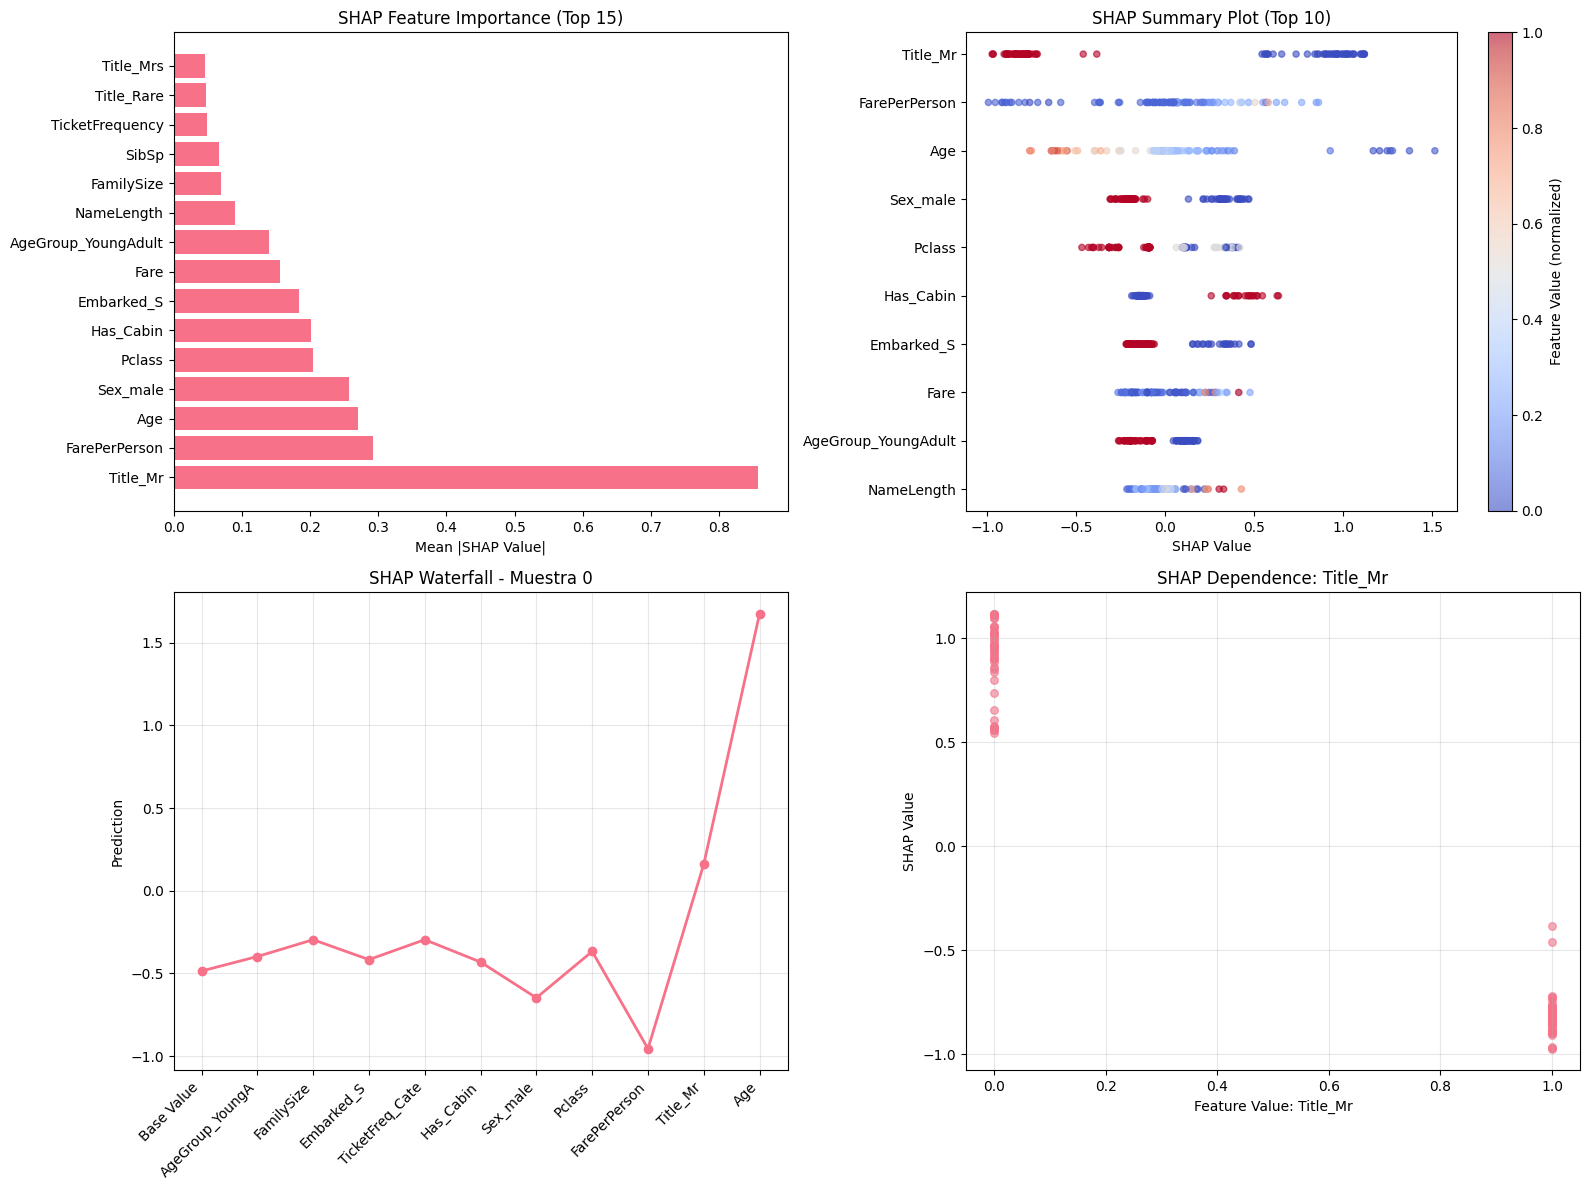


📈 ANÁLISIS CUANTITATIVO SHAP:
----------------------------------------
🏆 TOP 10 FEATURES POR SHAP IMPORTANCE:
    1. Title_Mr                       0.8570
    2. FarePerPerson                  0.2930
    3. Age                            0.2697
    4. Sex_male                       0.2570
    5. Pclass                         0.2040
    6. Has_Cabin                      0.2018
    7. Embarked_S                     0.1834
    8. Fare                           0.1558
    9. AgeGroup_YoungAdult            0.1395
   10. NameLength                     0.0896

🔗 Correlación XGBoost vs SHAP importance: 0.911

➡️ ANÁLISIS DE DIRECCIONALIDAD (SHAP):
   1. Title_Mr:
      • Impacto positivo: 46.0% de casos
      • SHAP promedio positivo: 0.9098
      • SHAP promedio negativo: -0.8120
   2. FarePerPerson:
      • Impacto positivo: 59.0% de casos
      • SHAP promedio positivo: 0.2449
      • SHAP promedio negativo: -0.3622
   3. Age:
      • Impacto positivo: 53.0% de casos
      • SHAP promedio

In [12]:
# 🔬 ANÁLISIS SHAP (SHapley Additive exPlanations)
print("🔬 ANÁLISIS SHAP PARA INTERPRETABILIDAD")
print("="*50)

if modelo is not None:
    
    try:
        import shap
        print("✅ SHAP importado correctamente")
        
        # Crear explainer para XGBoost
        explainer = shap.TreeExplainer(modelo)
        
        # Tomar muestra para SHAP (más eficiente)
        sample_size = min(100, len(X_val_processed))
        X_sample = X_val_processed[:sample_size]
        y_sample = y_val.iloc[:sample_size]
        
        print(f"📊 Calculando SHAP values para {sample_size} muestras...")
        shap_values = explainer.shap_values(X_sample)
        
        # Si SHAP devuelve array 3D, tomar la clase positiva
        if len(shap_values.shape) == 3:
            shap_values = shap_values[:, :, 1]  # Clase positiva (Sobrevivió)
        elif isinstance(shap_values, list):
            shap_values = shap_values[1]  # Clase positiva
        
        # Obtener nombres de features limpios
        feature_names_clean = []
        feature_names_original = preprocessor.get_feature_names_out()
        
        for fname in feature_names_original:
            if fname.startswith('num__'):
                clean_name = fname.replace('num__', '')
                feature_names_clean.append(clean_name)
            elif fname.startswith('cat__'):
                clean_name = fname.replace('cat__', '')
                if '_' in clean_name:
                    var_name, value = clean_name.split('_', 1)
                    feature_names_clean.append(f"{var_name}_{value}")
                else:
                    feature_names_clean.append(clean_name)
            else:
                feature_names_clean.append(fname)
        
        # 1. VISUALIZACIONES SHAP
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Gráfico 1: SHAP Feature Importance (bar plot)
        plt.subplot(2, 2, 1)
        shap_importance = np.abs(shap_values).mean(0)
        top_indices = np.argsort(shap_importance)[-15:]  # Top 15
        
        plt.barh(range(len(top_indices)), shap_importance[top_indices])
        plt.yticks(range(len(top_indices)), [feature_names_clean[i] for i in top_indices])
        plt.xlabel('Mean |SHAP Value|')
        plt.title('SHAP Feature Importance (Top 15)')
        plt.gca().invert_yaxis()
        
        # Gráfico 2: SHAP Summary Plot (manual)
        plt.subplot(2, 2, 2)
        # Crear summary plot manual
        for i, idx in enumerate(top_indices[-10:]):  # Top 10 para claridad
            y_pos = i
            shap_vals_feature = shap_values[:, idx]
            feature_vals = X_sample[:, idx]
            
            # Normalizar valores de feature para color
            if feature_vals.std() > 0:
                feature_vals_norm = (feature_vals - feature_vals.min()) / (feature_vals.max() - feature_vals.min())
            else:
                feature_vals_norm = np.zeros_like(feature_vals)
            
            scatter = plt.scatter(shap_vals_feature, [y_pos] * len(shap_vals_feature), 
                                 c=feature_vals_norm, cmap='coolwarm', alpha=0.6, s=20)
        
        plt.yticks(range(len(top_indices[-10:])), [feature_names_clean[i] for i in top_indices[-10:]])
        plt.xlabel('SHAP Value')
        plt.title('SHAP Summary Plot (Top 10)')
        plt.colorbar(scatter, label='Feature Value (normalized)')
        
        # Gráfico 3: SHAP Waterfall para una muestra
        plt.subplot(2, 2, 3)
        sample_idx = 0
        expected_value = explainer.expected_value
        if isinstance(expected_value, (list, np.ndarray)):
            expected_value = expected_value[1] if len(expected_value) > 1 else expected_value[0]
        
        # Crear waterfall plot manual
        shap_sample = shap_values[sample_idx]
        top_features_waterfall = np.argsort(np.abs(shap_sample))[-10:]
        
        cumsum = expected_value
        x_pos = [0]
        y_pos = [expected_value]
        labels = ['Base Value']
        
        for i, feat_idx in enumerate(top_features_waterfall):
            cumsum += shap_sample[feat_idx]
            x_pos.append(i + 1)
            y_pos.append(cumsum)
            labels.append(feature_names_clean[feat_idx][:15])
        
        plt.plot(x_pos, y_pos, 'o-', linewidth=2, markersize=6)
        plt.xticks(x_pos, labels, rotation=45, ha='right')
        plt.ylabel('Prediction')
        plt.title(f'SHAP Waterfall - Muestra {sample_idx}')
        plt.grid(True, alpha=0.3)
        
        # Gráfico 4: SHAP Dependence Plot
        plt.subplot(2, 2, 4)
        most_important_feature_idx = np.abs(shap_values).mean(0).argmax()
        
        plt.scatter(X_sample[:, most_important_feature_idx], 
                   shap_values[:, most_important_feature_idx],
                   alpha=0.6, s=30)
        plt.xlabel(f'Feature Value: {feature_names_clean[most_important_feature_idx]}')
        plt.ylabel('SHAP Value')
        plt.title(f'SHAP Dependence: {feature_names_clean[most_important_feature_idx]}')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 2. ANÁLISIS CUANTITATIVO SHAP
        print("\n📈 ANÁLISIS CUANTITATIVO SHAP:")
        print("-" * 40)
        
        # Top features por importancia SHAP
        shap_importance = np.abs(shap_values).mean(0)
        shap_ranking = np.argsort(shap_importance)[::-1]
        
        print("🏆 TOP 10 FEATURES POR SHAP IMPORTANCE:")
        for i, feat_idx in enumerate(shap_ranking[:10], 1):
            feat_name = feature_names_clean[feat_idx]
            importance = shap_importance[feat_idx]
            print(f"   {i:2d}. {feat_name:<30} {importance:.4f}")
        
        # Correlación entre importancia XGBoost y SHAP
        xgb_importance = modelo.feature_importances_
        correlation = np.corrcoef(xgb_importance, shap_importance)[0, 1]
        print(f"\n🔗 Correlación XGBoost vs SHAP importance: {correlation:.3f}")
        
        # Análisis de direccionalidad
        print(f"\n➡️ ANÁLISIS DE DIRECCIONALIDAD (SHAP):")
        for i, feat_idx in enumerate(shap_ranking[:5], 1):
            feat_name = feature_names_clean[feat_idx]
            positive_impact = (shap_values[:, feat_idx] > 0).mean() * 100
            mean_positive = shap_values[shap_values[:, feat_idx] > 0, feat_idx].mean() if np.any(shap_values[:, feat_idx] > 0) else 0
            mean_negative = shap_values[shap_values[:, feat_idx] < 0, feat_idx].mean() if np.any(shap_values[:, feat_idx] < 0) else 0
            
            print(f"   {i}. {feat_name}:")
            print(f"      • Impacto positivo: {positive_impact:.1f}% de casos")
            print(f"      • SHAP promedio positivo: {mean_positive:.4f}")
            print(f"      • SHAP promedio negativo: {mean_negative:.4f}")
        
        # 3. CASOS EJEMPLO
        print(f"\n🔍 CASOS EJEMPLO INTERPRETACIÓN SHAP:")
        print("-" * 40)
        
        # Caso con mayor predicción positiva
        predictions = modelo.predict_proba(X_sample)[:, 1]
        max_pred_idx = np.argmax(predictions)
        
        print(f"📈 CASO MAYOR PROBABILIDAD SUPERVIVENCIA:")
        print(f"   • Índice: {max_pred_idx}")
        print(f"   • Probabilidad predicha: {predictions[max_pred_idx]:.3f}")
        print(f"   • Real: {'Sobrevivió' if y_sample.iloc[max_pred_idx] == 1 else 'No sobrevivió'}")
        print(f"   • Top 3 factores contribuyentes:")
        
        top_contrib_idx = np.argsort(shap_values[max_pred_idx])[-3:][::-1]
        for j, feat_idx in enumerate(top_contrib_idx, 1):
            feat_name = feature_names_clean[feat_idx]
            shap_val = shap_values[max_pred_idx, feat_idx]
            print(f"      {j}. {feat_name}: SHAP = {shap_val:.4f}")
        
        # Caso con menor predicción
        min_pred_idx = np.argmin(predictions)
        
        print(f"\n📉 CASO MENOR PROBABILIDAD SUPERVIVENCIA:")
        print(f"   • Índice: {min_pred_idx}")
        print(f"   • Probabilidad predicha: {predictions[min_pred_idx]:.3f}")
        print(f"   • Real: {'Sobrevivió' if y_sample.iloc[min_pred_idx] == 1 else 'No sobrevivió'}")
        print(f"   • Top 3 factores que reducen supervivencia:")
        
        bottom_contrib_idx = np.argsort(shap_values[min_pred_idx])[:3]
        for j, feat_idx in enumerate(bottom_contrib_idx, 1):
            feat_name = feature_names_clean[feat_idx]
            shap_val = shap_values[min_pred_idx, feat_idx]
            print(f"      {j}. {feat_name}: SHAP = {shap_val:.4f}")
        
        print(f"\n✅ Análisis SHAP completado exitosamente")
        
    except ImportError:
        print("⚠️ SHAP no está instalado.")
        print("💡 Para instalar: pip install shap")
        print("📌 Continuando sin análisis SHAP...")
        
    except Exception as e:
        print(f"⚠️ Error en análisis SHAP: {str(e)}")
        print("📌 Continuando sin análisis SHAP...")
        
else:
    print("❌ Modelo no disponible para análisis SHAP")

🔍 ANÁLISIS LIME PARA EXPLICACIONES LOCALES
✅ LIME importado correctamente
📊 LIME explainer creado con 89 features

🎯 ANALIZANDO 4 CASOS CON LIME:
----------------------------------------

🔍 Explicando caso: Alta_Supervivencia (índice 38)
   • Probabilidad predicha: 0.926
   • Resultado real: Sobrevivió
   • Correcta: ✅
   • Top 5 factores explicativos:
      1. 🔼 Title_Mr <= 0.00: 0.3352
      2. 🔽 Age > 0.62: -0.1277
      3. 🔼 FarePerPerson > 0.20: 0.1150
      4. 🔼 Has_Cabin > -0.52: 0.1061
      5. 🔼 Sex_male <= 0.00: 0.0894

🔍 Explicando caso: Baja_Supervivencia (índice 36)
   • Probabilidad predicha: 0.037
   • Resultado real: No sobrevivió
   • Correcta: ✅
   • Top 5 factores explicativos:
      1. 🔽 0.00 < Title_Mr <= 1.00: -0.3271
      2. 🔽 FarePerPerson <= -0.47: -0.1786
      3. 🔽 Age > 0.62: -0.1218
      4. 🔽 Has_Cabin <= -0.52: -0.1164
      5. 🔼 Embarked_S <= 0.00: 0.0927

🔍 Explicando caso: Caso_Medio (índice 19)
   • Probabilidad predicha: 0.194
   • Resultado real: N

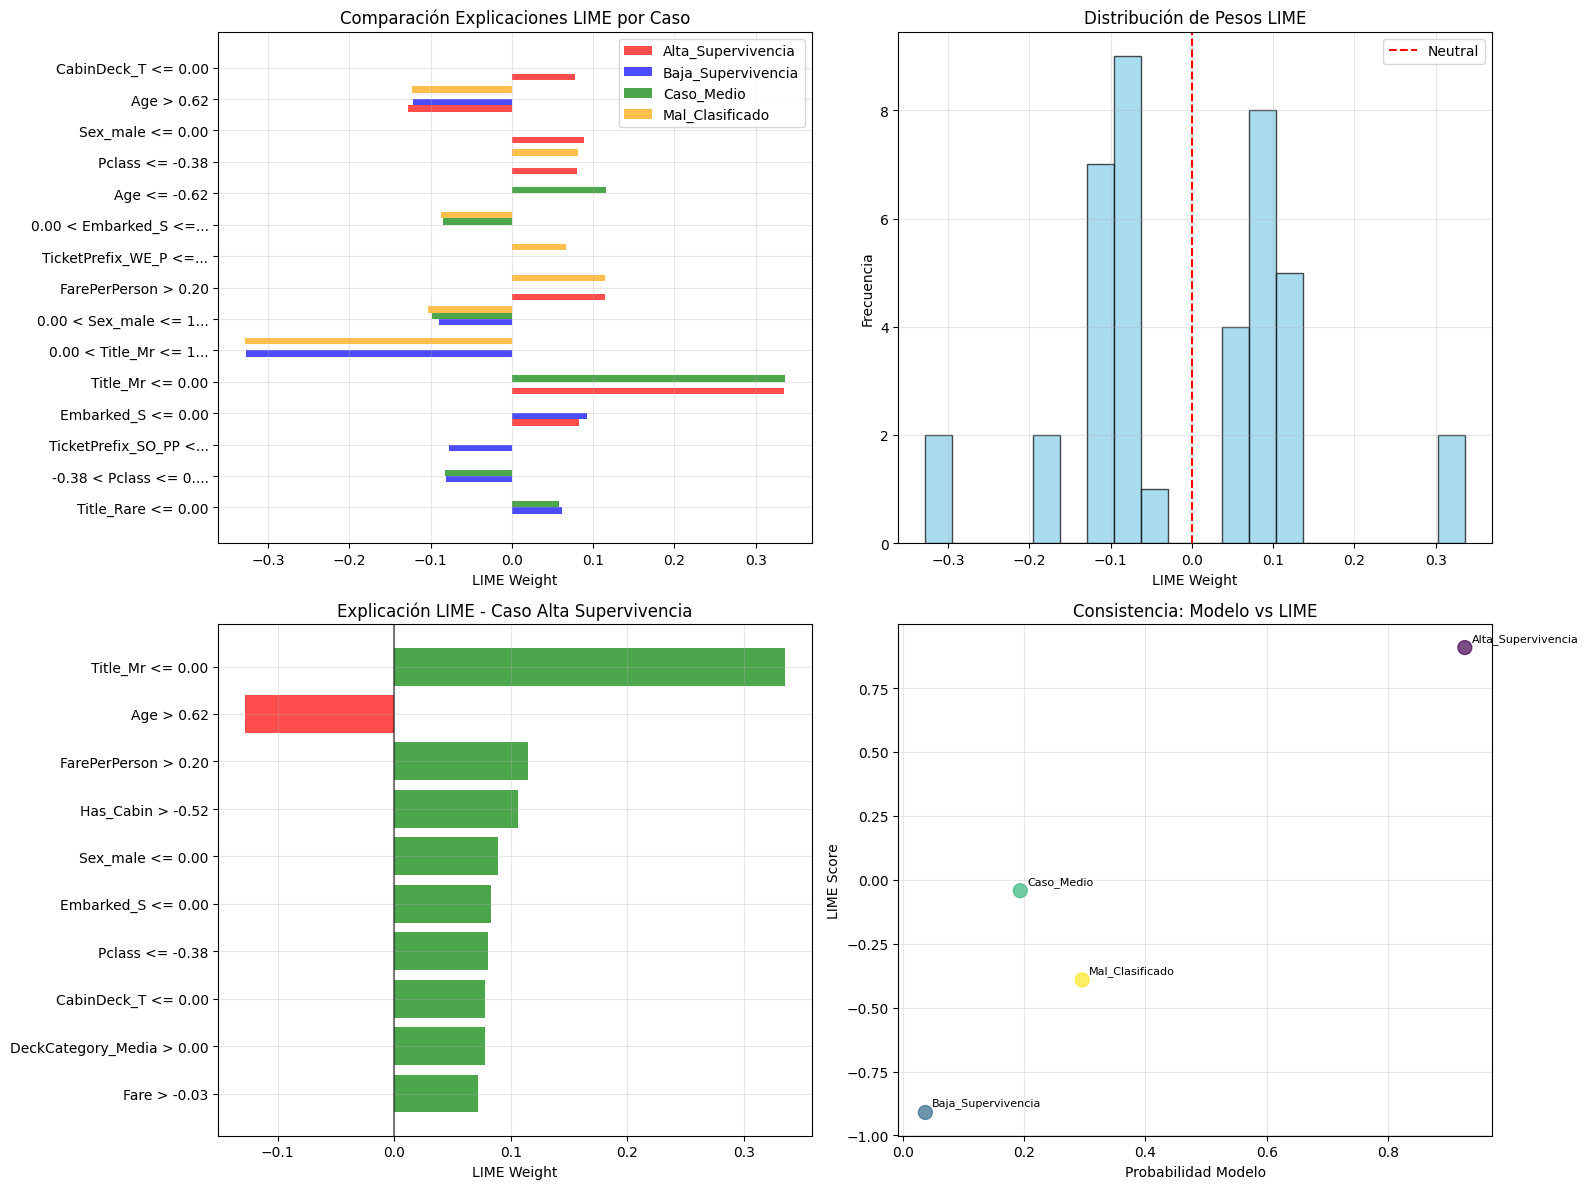


📊 ANÁLISIS COMPARATIVO LIME:
----------------------------------------
🏆 TOP 10 FEATURES MÁS IMPORTANTES SEGÚN LIME:
    1. Title_Mr <= 0.00                    0.3355
    2. 0.00 < Title_Mr <= 1.00             0.3275
    3. FarePerPerson <= -0.47              0.1765
    4. Age > 0.62                          0.1239
    5. Age <= -0.62                        0.1164
    6. Has_Cabin <= -0.52                  0.1152
    7. FarePerPerson > 0.20                0.1152
    8. Has_Cabin > -0.52                   0.1059
    9. 0.00 < Sex_male <= 1.00             0.0967
   10. Sex_male <= 0.00                    0.0894

🔄 CONSISTENCIA ENTRE CASOS:
   • Features comunes en todas las explicaciones: 0

✅ Análisis LIME completado exitosamente


In [14]:
# 🔍 ANÁLISIS LIME (Local Interpretable Model-agnostic Explanations)
print("🔍 ANÁLISIS LIME PARA EXPLICACIONES LOCALES")
print("="*50)

if modelo is not None:
    
    try:
        import lime
        import lime.lime_tabular
        print("✅ LIME importado correctamente")
        
        # Preparar datos para LIME
        feature_names_clean = []
        feature_names_original = preprocessor.get_feature_names_out()
        
        for fname in feature_names_original:
            if fname.startswith('num__'):
                clean_name = fname.replace('num__', '')
                feature_names_clean.append(clean_name)
            elif fname.startswith('cat__'):
                clean_name = fname.replace('cat__', '')
                if '_' in clean_name:
                    var_name, value = clean_name.split('_', 1)
                    feature_names_clean.append(f"{var_name}_{value}")
                else:
                    feature_names_clean.append(clean_name)
            else:
                feature_names_clean.append(fname)
        
        # Crear explainer LIME
        explainer = lime.lime_tabular.LimeTabularExplainer(
            X_train_processed,
            feature_names=feature_names_clean,
            class_names=['No Sobrevivió', 'Sobrevivió'],
            mode='classification'
        )
        
        print(f"📊 LIME explainer creado con {len(feature_names_clean)} features")
        
        # Función wrapper para predicciones
        def predict_proba_wrapper(X):
            return modelo.predict_proba(X)
        
        # Seleccionar casos interesantes para explicar
        sample_size = min(50, len(X_val_processed))
        predictions = modelo.predict_proba(X_val_processed[:sample_size])[:, 1]
        
        # Casos de interés
        casos_interes = {
            'Alta_Supervivencia': np.argmax(predictions),
            'Baja_Supervivencia': np.argmin(predictions),
            'Caso_Medio': np.argsort(predictions)[len(predictions)//2],
        }
        
        # Agregar casos mal clasificados si existen
        y_pred_sample = (predictions > 0.5).astype(int)
        y_true_sample = y_val.iloc[:sample_size].values
        misclassified = np.where(y_pred_sample != y_true_sample)[0]
        
        if len(misclassified) > 0:
            casos_interes['Mal_Clasificado'] = misclassified[0]
        
        # 1. ANÁLISIS LIME POR CASOS
        lime_explanations = {}
        
        print(f"\n🎯 ANALIZANDO {len(casos_interes)} CASOS CON LIME:")
        print("-" * 40)
        
        for caso_nombre, caso_idx in casos_interes.items():
            try:
                print(f"\n🔍 Explicando caso: {caso_nombre} (índice {caso_idx})")
                
                # Generar explicación LIME
                exp = explainer.explain_instance(
                    X_val_processed[caso_idx], 
                    predict_proba_wrapper, 
                    num_features=10,
                    top_labels=2
                )
                
                lime_explanations[caso_nombre] = exp
                
                # Información del caso
                prob_supervivencia = predictions[caso_idx]
                real_supervivencia = y_val.iloc[caso_idx]
                
                print(f"   • Probabilidad predicha: {prob_supervivencia:.3f}")
                print(f"   • Resultado real: {'Sobrevivió' if real_supervivencia == 1 else 'No sobrevivió'}")
                print(f"   • Correcta: {'✅' if (prob_supervivencia > 0.5) == real_supervivencia else '❌'}")
                
                # Top factores de la explicación
                exp_list = exp.as_list(label=1)  # Clase "Sobrevivió"
                print(f"   • Top 5 factores explicativos:")
                for i, (feature, weight) in enumerate(exp_list[:5], 1):
                    direction = "🔼" if weight > 0 else "🔽"
                    print(f"      {i}. {direction} {feature}: {weight:.4f}")
                    
            except Exception as e:
                print(f"   ⚠️ Error explicando caso {caso_nombre}: {str(e)[:50]}...")
        
        # 2. VISUALIZACIÓN LIME
        if lime_explanations:
            
            fig, axes = plt.subplots(2, 2, figsize=(16, 12))
            
            # Gráfico 1: Comparación de explicaciones por caso
            caso_colors = ['red', 'blue', 'green', 'orange']
            ax1 = axes[0, 0]
            
            all_features = set()
            for exp in lime_explanations.values():
                exp_dict = dict(exp.as_list(label=1))
                all_features.update(exp_dict.keys())
            
            all_features = list(all_features)[:15]  # Top 15 para claridad
            x_pos = np.arange(len(all_features))
            
            for i, (caso_nombre, exp) in enumerate(lime_explanations.items()):
                exp_dict = dict(exp.as_list(label=1))
                weights = [exp_dict.get(feat, 0) for feat in all_features]
                
                ax1.barh(x_pos + i*0.2, weights, 0.2, 
                        label=caso_nombre, color=caso_colors[i % len(caso_colors)], alpha=0.7)
            
            ax1.set_yticks(x_pos + 0.3)
            ax1.set_yticklabels([f[:20] + "..." if len(f) > 20 else f for f in all_features])
            ax1.set_xlabel('LIME Weight')
            ax1.set_title('Comparación Explicaciones LIME por Caso')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Gráfico 2: Distribución de pesos LIME
            ax2 = axes[0, 1]
            all_weights = []
            for exp in lime_explanations.values():
                weights = [w for _, w in exp.as_list(label=1)]
                all_weights.extend(weights)
            
            ax2.hist(all_weights, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            ax2.set_xlabel('LIME Weight')
            ax2.set_ylabel('Frecuencia')
            ax2.set_title('Distribución de Pesos LIME')
            ax2.axvline(x=0, color='red', linestyle='--', label='Neutral')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # Gráfico 3: Caso específico detallado
            ax3 = axes[1, 0]
            if 'Alta_Supervivencia' in lime_explanations:
                exp = lime_explanations['Alta_Supervivencia']
                exp_list = exp.as_list(label=1)[:10]
                
                features = [f[0] for f in exp_list]
                weights = [f[1] for f in exp_list]
                colors = ['green' if w > 0 else 'red' for w in weights]
                
                bars = ax3.barh(range(len(features)), weights, color=colors, alpha=0.7)
                ax3.set_yticks(range(len(features)))
                ax3.set_yticklabels([f[:25] + "..." if len(f) > 25 else f for f in features])
                ax3.set_xlabel('LIME Weight')
                ax3.set_title('Explicación LIME - Caso Alta Supervivencia')
                ax3.axvline(x=0, color='black', linestyle='-', alpha=0.5)
                ax3.grid(True, alpha=0.3)
                ax3.invert_yaxis()
            
            # Gráfico 4: Consistencia LIME vs modelo
            ax4 = axes[1, 1]
            
            # Calcular consistencia: comparar predicciones modelo vs LIME score
            consistency_scores = []
            lime_scores = []
            model_probs = []
            
            for caso_nombre, exp in lime_explanations.items():
                caso_idx = casos_interes[caso_nombre]
                model_prob = predictions[caso_idx]
                
                # LIME score como suma ponderada
                exp_list = exp.as_list(label=1)
                lime_score = sum([w for _, w in exp_list])
                
                consistency_scores.append(caso_nombre)
                lime_scores.append(lime_score)
                model_probs.append(model_prob)
            
            scatter = ax4.scatter(model_probs, lime_scores, s=100, alpha=0.7, c=range(len(model_probs)), cmap='viridis')
            ax4.set_xlabel('Probabilidad Modelo')
            ax4.set_ylabel('LIME Score')
            ax4.set_title('Consistencia: Modelo vs LIME')
            
            # Agregar etiquetas
            for i, caso in enumerate(consistency_scores):
                ax4.annotate(caso, (model_probs[i], lime_scores[i]), 
                           xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
        
        # 3. ANÁLISIS COMPARATIVO LIME
        print(f"\n📊 ANÁLISIS COMPARATIVO LIME:")
        print("-" * 40)
        
        if len(lime_explanations) >= 2:
            # Comparar features más importantes
            feature_importance_lime = {}
            
            for caso_nombre, exp in lime_explanations.items():
                for feature, weight in exp.as_list(label=1):
                    if feature not in feature_importance_lime:
                        feature_importance_lime[feature] = []
                    feature_importance_lime[feature].append(abs(weight))
            
            # Calcular importancia promedio
            avg_importance = {}
            for feature, weights in feature_importance_lime.items():
                avg_importance[feature] = np.mean(weights)
            
            # Top features por LIME
            sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
            
            print("🏆 TOP 10 FEATURES MÁS IMPORTANTES SEGÚN LIME:")
            for i, (feature, importance) in enumerate(sorted_features[:10], 1):
                print(f"   {i:2d}. {feature:<35} {importance:.4f}")
            
            # Consistencia entre casos
            print(f"\n🔄 CONSISTENCIA ENTRE CASOS:")
            common_features = set.intersection(*[set(dict(exp.as_list(label=1)).keys()) 
                                               for exp in lime_explanations.values()])
            print(f"   • Features comunes en todas las explicaciones: {len(common_features)}")
            
            if common_features:
                print("   • Features consistentes:")
                for feature in list(common_features)[:5]:
                    weights = []
                    for exp in lime_explanations.values():
                        exp_dict = dict(exp.as_list(label=1))
                        weights.append(exp_dict.get(feature, 0))
                    
                    avg_weight = np.mean(weights)
                    std_weight = np.std(weights)
                    print(f"      • {feature}: μ={avg_weight:.4f}, σ={std_weight:.4f}")
        
        print(f"\n✅ Análisis LIME completado exitosamente")
        
    except ImportError:
        print("⚠️ LIME no está instalado.")
        print("💡 Para instalar: pip install lime")
        print("📌 Continuando sin análisis LIME...")
        
    except Exception as e:
        print(f"⚠️ Error en análisis LIME: {str(e)}")
        print("📌 Continuando sin análisis LIME...")
        
else:
    print("❌ Modelo no disponible para análisis LIME")

In [10]:
print("🔄 CARGANDO MODELO Y DATOS DESDE MODELADO (RF)")
print("="*50)

try:
    # Cargar el modelo entrenado
    if os.path.exists("models/randomforest_model.pkl"):
        modelo_rf = joblib.load("models/randomforest_model.pkl")
        print("✅ Modelo RandomForest cargado desde archivo")
    else:
        print("⚠️ Archivo del modelo no encontrado. Ejecutar primero el notebook de modelado.")
        modelo_rf = None

    # Cargar datos originales
    data_path_rf = Path("../Entrega2/data/")
    df_rf = pd.read_csv(data_path_rf / "Titanic_Dataset_Featured.csv")
    print(f"✅ Dataset cargado: {df_rf.shape}")

    # Preprocessing
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler, OneHotEncoder
    from sklearn.compose import ColumnTransformer

    X_rf = df_rf.drop('Survived', axis=1)
    y_rf = df_rf['Survived']

    numeric_features_rf = X_rf.select_dtypes(include=['int64', 'float64']).columns.tolist()
    all_categorical_rf = X_rf.select_dtypes(include=['object']).columns.tolist()
    variables_excluir_rf = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    categorical_features_rf = [col for col in all_categorical_rf if col not in variables_excluir_rf]

    if 'PassengerId' in numeric_features_rf:
        numeric_features_rf.remove('PassengerId')

    features_seleccionadas_rf = numeric_features_rf + categorical_features_rf
    X_rf = X_rf[features_seleccionadas_rf]

    preprocessor_rf = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features_rf),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features_rf)
        ]
    )

    X_train_rf, X_temp_rf, y_train_rf, y_temp_rf = train_test_split(
        X_rf, y_rf, test_size=0.4, random_state=42, stratify=y_rf
    )
    X_val_rf, X_test_rf, y_val_rf, y_test_rf = train_test_split(
        X_temp_rf, y_temp_rf, test_size=0.5, random_state=42, stratify=y_temp_rf
    )

    X_train_processed_rf = preprocessor_rf.fit_transform(X_train_rf)
    X_val_processed_rf = preprocessor_rf.transform(X_val_rf)
    X_test_processed_rf = preprocessor_rf.transform(X_test_rf)

    print(f"✅ Datos procesados:")
    print(f"   - Train: {X_train_processed_rf.shape}")
    print(f"   - Validation: {X_val_processed_rf.shape}")
    print(f"   - Test: {X_test_processed_rf.shape}")

    if modelo_rf is not None:
        y_pred_val_rf = modelo_rf.predict(X_val_processed_rf)
        y_pred_proba_val_rf = modelo_rf.predict_proba(X_val_processed_rf)[:, 1]

        y_pred_test_rf = modelo_rf.predict(X_test_processed_rf)
        y_pred_proba_test_rf = modelo_rf.predict_proba(X_test_processed_rf)[:, 1]

        print("✅ Predicciones generadas para validación y test")

    print("\n🎯 DATOS LISTOS PARA ANÁLISIS DE INTERPRETABILIDAD (RF)")

except Exception as e:
    print(f"❌ Error al cargar datos: {str(e)}")
    print("💡 Asegúrate de ejecutar primero el notebook de modelado")

🔄 CARGANDO MODELO Y DATOS DESDE MODELADO (RF)
✅ Modelo RandomForest cargado desde archivo
✅ Dataset cargado: (891, 36)
✅ Datos procesados:
   - Train: (534, 89)
   - Validation: (178, 89)
   - Test: (179, 89)
✅ Predicciones generadas para validación y test

🎯 DATOS LISTOS PARA ANÁLISIS DE INTERPRETABILIDAD (RF)


🔎 MÉTRICAS BÁSICAS RANDOM FOREST
   • Accuracy: 0.8427
   • Precision: 0.8030
   • Recall: 0.7794
   • F1-Score: 0.7910
   • ROC-AUC: 0.8937
   • PR-AUC: 0.8870
   • MCC: 0.6652
   • Balanced Accuracy: 0.8306
   • Brier Score: 0.1235
   • Tiempo de entrenamiento: 0.00 s
   • Tiempo de inferencia: 0.0150 s


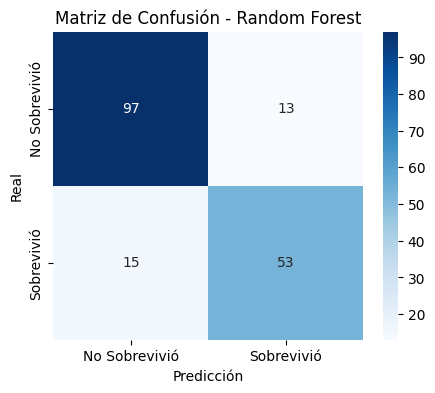


📋 TABLA RESUMEN POR GRUPOS:
            Grupo   N  Accuracy  Precision  Recall    F1  ROC_AUC
      Género_male 113     0.876      0.692   0.474 0.562    0.741
    Género_female  65     0.785      0.830   0.898 0.863    0.867
          Clase_1  41     0.878      0.923   0.889 0.906    0.921
          Clase_2  37     0.892      0.900   0.900 0.900    0.947
          Clase_3 100     0.810      0.550   0.524 0.537    0.770
    Edad_Menor_18  32     0.906      0.867   0.929 0.897    0.944
      Edad_Adulto  39     0.846      0.867   0.765 0.812    0.925
Edad_Adulto_Joven 102     0.833      0.765   0.743 0.754    0.872
       Edad_Mayor   5     0.600      0.500   0.500 0.500    0.500
  Familia_Pequeña  48     0.792      0.812   0.867 0.839    0.889
     Familia_Solo 109     0.844      0.750   0.677 0.712    0.848
   Familia_Grande  21     0.952      1.000   0.857 0.923    0.980


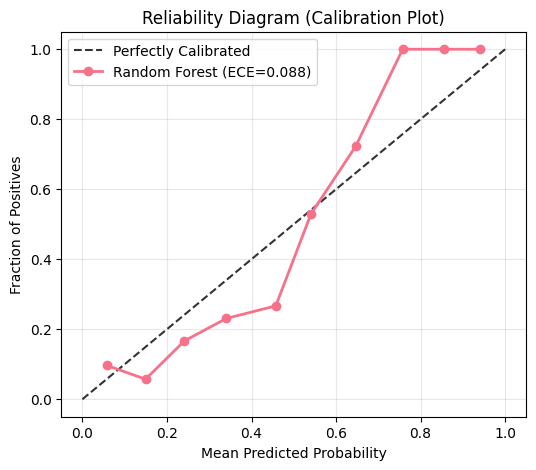


Brier Score: 0.1235
Expected Calibration Error (ECE): 0.0875


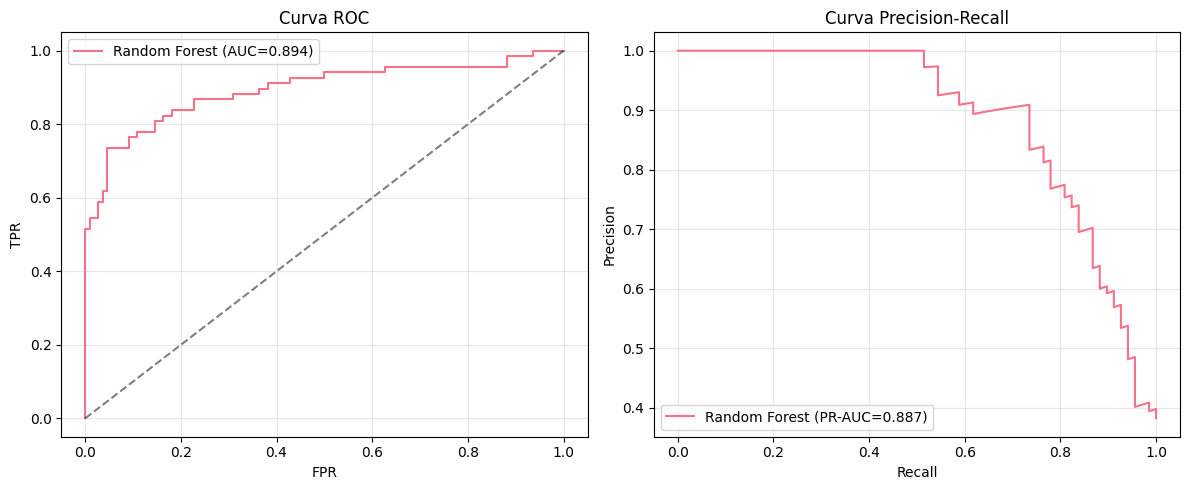

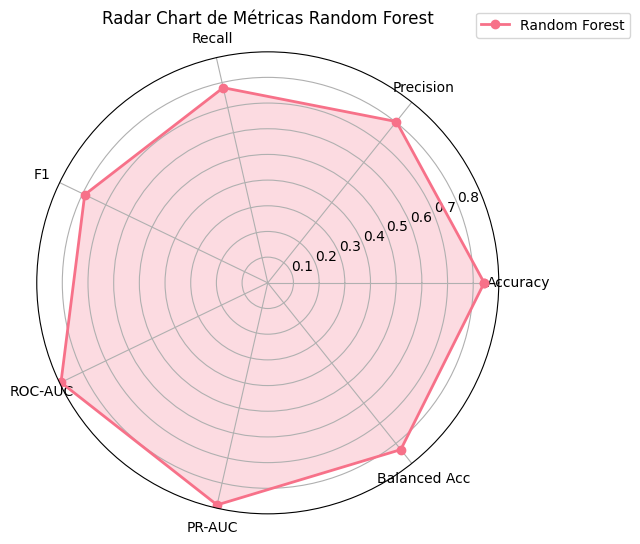


📊 TABLA COMPARATIVA DE MODELOS
       Modelo  Accuracy  Precision  Recall    F1  ROC-AUC  PR-AUC  Balanced Accuracy  Brier Score
Random Forest     0.843      0.803   0.779 0.791    0.894   0.887              0.831        0.123
      XGBoost     0.826      0.825   0.691 0.752    0.886   0.879              0.800        0.118


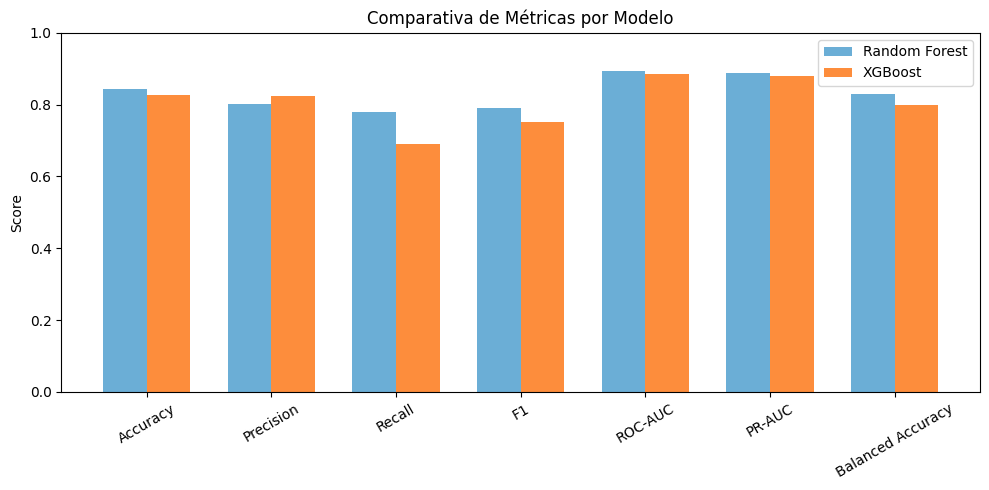

In [18]:
import time
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, precision_recall_curve, auc, matthews_corrcoef, balanced_accuracy_score,
                             brier_score_loss, roc_curve)
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# 1. PREDICCIONES Y MÉTRICAS BÁSICAS
print("🔎 MÉTRICAS BÁSICAS RANDOM FOREST")
start_train = time.time()
# Si ya cargaste modelo_rf y los datos *_rf, no necesitas volver a cargar
# modelo_rf = joblib.load("models/randomforest_model.pkl")
# modelo_rf.fit(X_train_processed_rf, y_train_rf)  # Solo si no está entrenado

train_time = time.time() - start_train

start_inf = time.time()
y_pred_val_rf = modelo_rf.predict(X_val_processed_rf)
y_pred_proba_val_rf = modelo_rf.predict_proba(X_val_processed_rf)[:, 1]
inf_time = time.time() - start_inf

accuracy_rf = accuracy_score(y_val_rf, y_pred_val_rf)
precision_rf = precision_score(y_val_rf, y_pred_val_rf)
recall_rf = recall_score(y_val_rf, y_pred_val_rf)
f1_rf = f1_score(y_val_rf, y_pred_val_rf)
roc_auc_rf = roc_auc_score(y_val_rf, y_pred_proba_val_rf)
precision_curve_rf, recall_curve_rf, _ = precision_recall_curve(y_val_rf, y_pred_proba_val_rf)
pr_auc_rf = auc(recall_curve_rf, precision_curve_rf)
mcc_rf = matthews_corrcoef(y_val_rf, y_pred_val_rf)
balanced_acc_rf = balanced_accuracy_score(y_val_rf, y_pred_val_rf)
brier_score_rf = brier_score_loss(y_val_rf, y_pred_proba_val_rf)

print(f"   • Accuracy: {accuracy_rf:.4f}")
print(f"   • Precision: {precision_rf:.4f}")
print(f"   • Recall: {recall_rf:.4f}")
print(f"   • F1-Score: {f1_rf:.4f}")
print(f"   • ROC-AUC: {roc_auc_rf:.4f}")
print(f"   • PR-AUC: {pr_auc_rf:.4f}")
print(f"   • MCC: {mcc_rf:.4f}")
print(f"   • Balanced Accuracy: {balanced_acc_rf:.4f}")
print(f"   • Brier Score: {brier_score_rf:.4f}")
print(f"   • Tiempo de entrenamiento: {train_time:.2f} s")
print(f"   • Tiempo de inferencia: {inf_time:.4f} s")

# 2. MATRIZ DE CONFUSIÓN DETALLADA
cm_rf = confusion_matrix(y_val_rf, y_pred_val_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=['No Sobrevivió', 'Sobrevivió'], yticklabels=['No Sobrevivió', 'Sobrevivió'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.show()

# 3. MÉTRICAS POR GRUPO
def calcular_metricas_grupo_rf(y_true, y_pred, y_pred_proba, grupo_nombre):
    if len(y_true) == 0:
        return None
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    if len(np.unique(y_true)) > 1:
        roc_auc = roc_auc_score(y_true, y_pred_proba)
        mcc = matthews_corrcoef(y_true, y_pred)
    else:
        roc_auc = np.nan
        mcc = np.nan
    return {
        'Grupo': grupo_nombre,
        'N': len(y_true),
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc,
        'MCC': mcc,
        'Tasa_Supervivencia_Real': y_true.mean(),
        'Tasa_Supervivencia_Pred': y_pred.mean()
    }

df_val_rf = df_rf.iloc[X_val_rf.index].copy()
resultados_grupos_rf = []

# Por Género
for genero in df_val_rf['Sex'].unique():
    mask = df_val_rf['Sex'] == genero
    metricas = calcular_metricas_grupo_rf(y_val_rf[mask], y_pred_val_rf[mask], y_pred_proba_val_rf[mask], f'Género_{genero}')
    if metricas: resultados_grupos_rf.append(metricas)

# Por Clase
for clase in sorted(df_val_rf['Pclass'].unique()):
    mask = df_val_rf['Pclass'] == clase
    metricas = calcular_metricas_grupo_rf(y_val_rf[mask], y_pred_val_rf[mask], y_pred_proba_val_rf[mask], f'Clase_{clase}')
    if metricas: resultados_grupos_rf.append(metricas)

# Por Edad
if 'Age' in df_val_rf.columns:
    df_val_rf['Grupo_Edad'] = pd.cut(df_val_rf['Age'], bins=[0, 18, 35, 60, 100], labels=['Menor_18', 'Adulto_Joven', 'Adulto', 'Mayor'])
    for grupo_edad in df_val_rf['Grupo_Edad'].dropna().unique():
        mask = df_val_rf['Grupo_Edad'] == grupo_edad
        metricas = calcular_metricas_grupo_rf(y_val_rf[mask], y_pred_val_rf[mask], y_pred_proba_val_rf[mask], f'Edad_{grupo_edad}')
        if metricas: resultados_grupos_rf.append(metricas)

# Por Tamaño de Familia
if 'FamilySize' in df_val_rf.columns:
    df_val_rf['Grupo_Familia'] = df_val_rf['FamilySize'].apply(lambda x: 'Solo' if x == 1 else 'Pequeña' if x <= 3 else 'Grande')
    for grupo_familia in df_val_rf['Grupo_Familia'].unique():
        mask = df_val_rf['Grupo_Familia'] == grupo_familia
        metricas = calcular_metricas_grupo_rf(y_val_rf[mask], y_pred_val_rf[mask], y_pred_proba_val_rf[mask], f'Familia_{grupo_familia}')
        if metricas: resultados_grupos_rf.append(metricas)

df_resultados_rf = pd.DataFrame(resultados_grupos_rf)
print("\n📋 TABLA RESUMEN POR GRUPOS:")
print(df_resultados_rf[['Grupo', 'N', 'Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC']].round(3).to_string(index=False))

# 4. ANÁLISIS DE CALIBRACIÓN
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_val_rf, y_pred_proba_val_rf, n_bins=10)
ece_rf = np.sum(np.abs(mean_predicted_value_rf - fraction_of_positives_rf) * np.histogram(y_pred_proba_val_rf, bins=10)[0] / len(y_val_rf))

plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'k--', alpha=0.8, label='Perfectly Calibrated')
plt.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', linewidth=2, label=f'Random Forest (ECE={ece_rf:.3f})')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram (Calibration Plot)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nBrier Score: {brier_score_rf:.4f}")
print(f"Expected Calibration Error (ECE): {ece_rf:.4f}")

# 5. VISUALIZACIONES COMPARATIVAS
# ROC y PR Curve
fpr_rf, tpr_rf, _ = roc_curve(y_val_rf, y_pred_proba_val_rf)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_rf:.3f})')
plt.plot([0,1],[0,1],'k--',alpha=0.5)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(recall_curve_rf, precision_curve_rf, label=f'Random Forest (PR-AUC={pr_auc_rf:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Radar chart de métricas
from math import pi
metrics_rf = [accuracy_rf, precision_rf, recall_rf, f1_rf, roc_auc_rf, pr_auc_rf, balanced_acc_rf]
labels_rf = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC', 'Balanced Acc']
angles_rf = np.linspace(0, 2 * np.pi, len(metrics_rf), endpoint=False).tolist()
metrics_rf += metrics_rf[:1]
angles_rf += angles_rf[:1]
plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)
ax.plot(angles_rf, metrics_rf, 'o-', linewidth=2, label='Random Forest')
ax.fill(angles_rf, metrics_rf, alpha=0.25)
ax.set_thetagrids(np.degrees(angles_rf[:-1]), labels_rf)
plt.title('Radar Chart de Métricas Random Forest')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()

print("\n📊 TABLA COMPARATIVA DE MODELOS")

tabla_comparativa = pd.DataFrame([
    {
        'Modelo': 'Random Forest',
        'Accuracy': accuracy_rf,
        'Precision': precision_rf,
        'Recall': recall_rf,
        'F1': f1_rf,
        'ROC-AUC': roc_auc_rf,
        'PR-AUC': pr_auc_rf,
        'Balanced Accuracy': balanced_acc_rf,
        'Brier Score': brier_score_rf
    },
    {
        'Modelo': 'XGBoost',
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC-AUC': roc_auc,
        'PR-AUC': pr_auc,
        'Balanced Accuracy': balanced_acc,
        'Brier Score': brier_score
    }
])

print(tabla_comparativa.round(3).to_string(index=False))


metricas = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC', 'Balanced Accuracy']
x = np.arange(len(metricas))
width = 0.35

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(x - width/2, tabla_comparativa.loc[0, metricas], width, label='Random Forest', color='#6baed6')
ax.bar(x + width/2, tabla_comparativa.loc[1, metricas], width, label='XGBoost', color='#fd8d3c')

ax.set_ylabel('Score')
ax.set_title('Comparativa de Métricas por Modelo')
ax.set_xticks(x)
ax.set_xticklabels(metricas, rotation=30)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.show()